# Outlier detection models on Generated datasets

## 1. Generated datasets
**The following notations are applied across**:
- In mathematical model, denote dataset $[\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_n] = \mathbf{X} \in \mathbb{R}^{d \times n}$.
- In PCA or python implementation, variables (columns) are feature vectors: $[\mathbf{x}_{\vec{1}}, \mathbf{x}_{\vec{2}}, ..., \mathbf{x}_{\vec{n}}]^T = \mathbf{X}^T \in \mathbb{R}^{n \times d}$, where $\mathbf{x}_{\vec{i}}$ is a row vector ($i^{th}$ row), representing an observation.

### a. sklearn datasets

In [1]:
from sklearn.datasets import make_s_curve, make_moons, make_blobs, make_swiss_roll
import numpy as np

n_samples = 500
outlier_percentage = 0.15

n_outliers = int(n_samples * outlier_percentage)
n_inliers = n_samples - n_outliers

rng = np.random.RandomState(42)

def get_2d_dataset():
    blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
    dataset = [
        # single blob
        make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
                **blobs_params)[0],
        # 2 blobs of similar density
        make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
                **blobs_params)[0],
        # 2 blobs of different density
        make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
                **blobs_params)[0],
        # 2 ellipses of similar density
        np.dot(make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
                **blobs_params)[0], [[1, -0.6], [-0.2, 1]]),
        # 2 ellipses of different density
        np.dot(make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
                **blobs_params)[0], [[1, -0.6], [-0.2, 1]]),
        # s
        make_s_curve(n_samples=n_inliers, noise=0.2)[0][:, (0,2)],
        # swiss roll
        np.dot(make_swiss_roll(n_samples=n_inliers, noise=0.7)[0][:, (0,2)], 0.3),
        # 2D crescents
        4. * (make_moons(n_samples=n_inliers, noise=.05, random_state=0)[0] -
            np.array([0.5, 0.25])),
        # uniform
        #14. * (rng.rand(n_samples, 2) - 0.5)
    ]

    outliers = rng.uniform(low=-7, high=7, size=(n_outliers, 2))
    return outliers, dataset

def get_md_dataset():
    blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=10)
    dataset = [
        make_blobs(
            centers=[np.zeros(10), np.zeros(10)],
            cluster_std=0.5,
            **blobs_params)[0],
        make_blobs(
            centers=[2*np.ones(10), (-2)*np.ones(10)],
            cluster_std=[0.5, 0.5],
            **blobs_params)[0],
        make_blobs(
            centers=[2*np.ones(10), (-2)*np.ones(10)],
            cluster_std=[1.5, .3],
            **blobs_params)[0],
        np.dot(
            make_blobs(
                centers=[2*np.ones(10), (-2)*np.ones(10)],
                cluster_std=[0.5, 0.5],
                **blobs_params)[0],
            np.zeros((10, 10)) - 0.5 + np.diag(2*np.ones(10))),
        np.dot(
            make_blobs(
                centers=[2*np.ones(10), (-2)*np.ones(10)],
                cluster_std=[1.5, 3],
                **blobs_params)[0],
            np.zeros((10, 10)) - 0.5 + np.diag(2*np.ones(10))),
        14. * (rng.rand(n_samples, 10) - 0.5)
    ]

    outliers = rng.uniform(low=-7, high=7, size=(n_outliers, 10))
    return outliers, dataset

### b. Plot & PCA
**2D data**

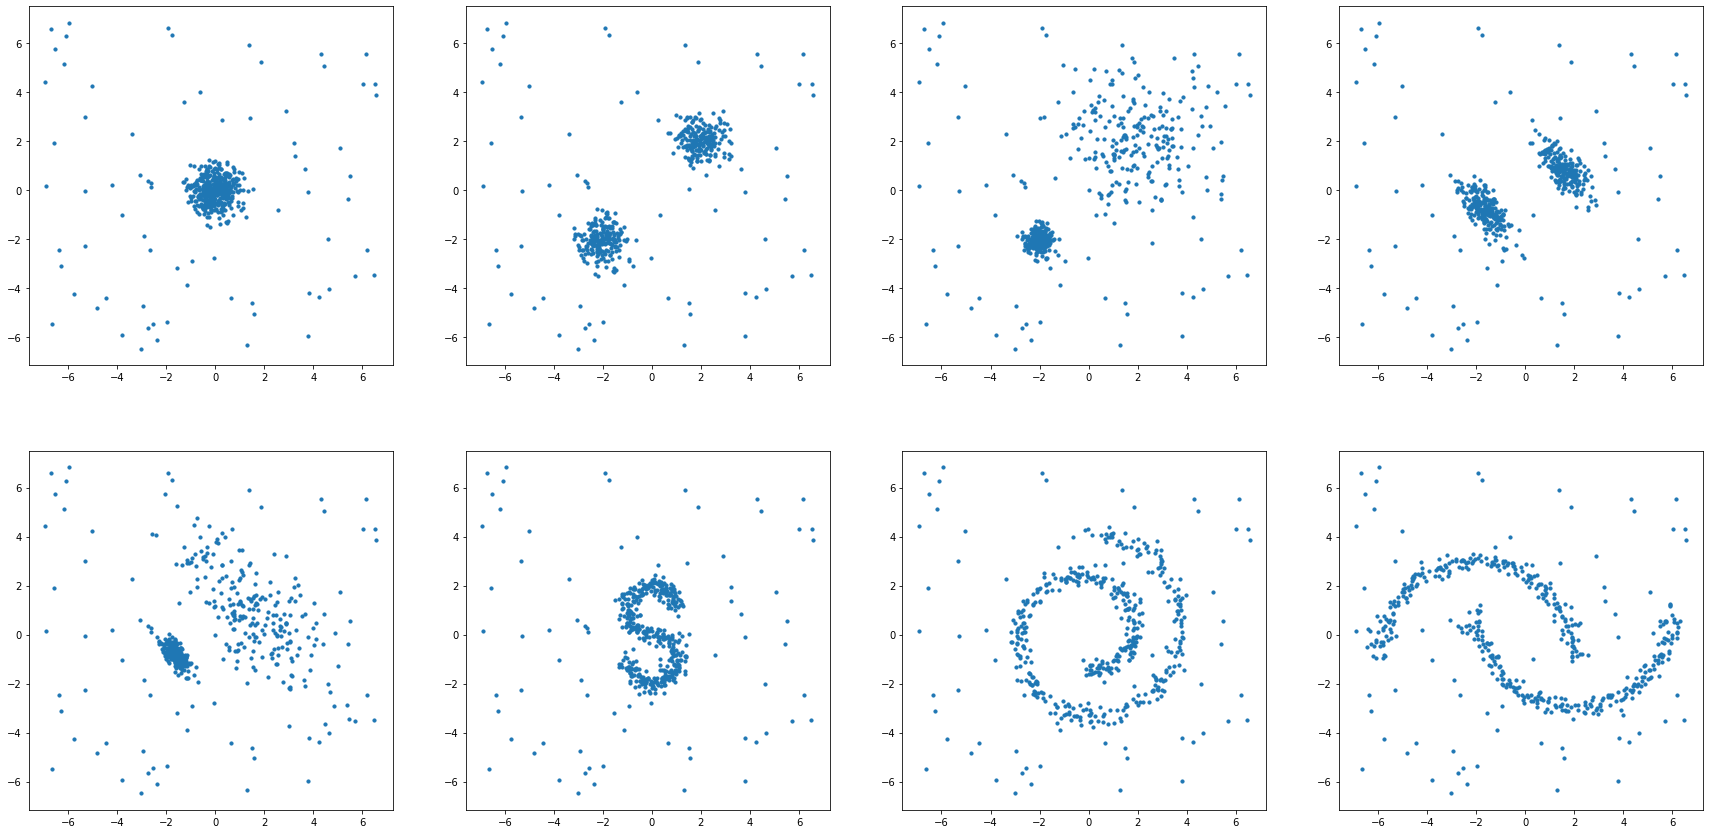

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 30))

outliers, ds = get_2d_dataset()

for dataset_i, inliers in enumerate(ds):
    X = np.concatenate([inliers, outliers], axis=0)

    if (dataset_i < 4):
        ax = fig.add_subplot(2, 4, dataset_i+1)
    elif (dataset_i < 8):
        ax = fig.add_subplot(1, 4, dataset_i+1-4)

    ax.set_aspect('equal')
    ax.scatter(X[:, 0], X[:, 1], s=10)

plt.show()

**10D Data & PCA**
- PCA is a dimensionality reduction method. Algebraically speaking, it finds a subspace of original data, which is obtained by projecting the original dataset $\mathbf{X} \in \mathbb{R}^{n \times d}$ (feature vectors), onto a set of orthonormal basis $[\mathbf{v}_1, \mathbf{v}_2, ..., \mathbf{v}_n] = \mathbf{V} \in \mathbb{R}^{d \times d}$. These projections minimize the projection loss, and maximizing the variance of projection lengths on each axis (Pearson, 1901) [3].
- The problem is simplified to a constraint optimization. With covariance matrix $\mathbf{\hat{X}}^T\mathbf{\hat{X}} = \mathbf{C} \in \mathbb{R}^{d \times d}$, where $\mathbf{\hat{X}}$ is the feature-mean-centered matrix of $\mathbf{X}$: $$ \begin{aligned}
  \mathbf{v}_1
    &= \underset{\mathbf{v}}{\text{argmin}}\ \frac{1}{n} \sum_{i=1}^n \| \mathbf{x}_{\vec{i}}-\mathbf{v}^T\mathbf{x}_{\vec{i}}\mathbf{v} \| \ \ s.t.  \| \mathbf{v} \| _2 =1\\
    &= \underset{\mathbf{v}}{\text{argmax}}\ \frac{1}{n} \sum_{i=1}^n\mathbf{v}^T\mathbf{x}_{\vec{i}}\mathbf{x}_{\vec{i}}^T\mathbf{v} = \underset{\mathbf{v}}{\text{argmax}}\ \mathbf{v}^T\mathbf{C}\mathbf{v} \ \ s.t.  \| \mathbf{v} \| _2 =1
\end{aligned}$$
- Using Lagrange multipliers $\lambda_1$ (Kamperis, 2000) [1] to solve this constraint optimization problem, we derive $(\lambda_1, \mathbf{v}_1)$ to be the eigenvalue-eigenvector pair of covariance matrix $\mathbf{C}$. $\mathbf{v}_2$ can be derived by solving a similar constraint optimization problem: $$ \begin{aligned}
  \mathbf{v}_2 = \underset{\mathbf{v}}{\text{argmax}}\ \mathbf{v}^T\mathbf{C}\mathbf{v} \ \ s.t.  \begin{cases}
  \| \mathbf{v} \| _2 &= 1\\
  \mathbf{v}^T\mathbf{v}_1 &= 0
  \end{cases}
\end{aligned}$$
- Solving this using Lagrange multipliers $\lambda_2, \mu$ gives us the next eigenvector-eigenvalue pair $(\lambda_2, \mathbf{v}_2)$. This process can be repeated until all eigenvalue-eigenvector pairs $( \lambda_1, \mathbf{v}_1), ( \lambda_2, \mathbf{v}_2), ..., ( \lambda_d, \mathbf{v}_d)$ are found (as orthonormal basis  axis). Without loss of generality, sort these so eigenvalues decrease in values (note that covariance matrix is positive-semi definite so eigenvalues are positive reals), we have the first axis captures the most variance, called the first principle component, the second axis captures the second most variances, called the second principle component, and so on.
- In relation to the SVD, denote the projection lengths as columns of matrix $\mathbf{W} = \mathbf{X}\mathbf{V}$. First we can bring the SVD to: $$ \begin{aligned}
  \mathbf{X} &= \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T \\
  \mathbf{X}^T \mathbf{X} &= \mathbf{V} \mathbf{\Sigma}^2\mathbf{V}^T  \\
  \mathbf{X}^T \mathbf{X}\mathbf{V} &= \mathbf{V} \mathbf{\Sigma}^2
\end{aligned} $$
- If we mean-center matrix $\mathbf{X}$, $\mathbf{V}$ in the SVD is the same $\mathbf{V}$ in the PCA. And squared diagonal entries $\mathbf{\sigma}_i^2$ of $\mathbf{\Sigma}$ is the eigenvalues $\lambda_i$. Therefore: $$\begin{aligned}
  \mathbf{W}
    &= \mathbf{X}\mathbf{V}\\
    &= \mathbf{U}\mathbf{\Sigma}
\end{aligned}$$
- If we use all of the principle components, we reconstruct the original dataset. If we use the first $r \leq d$ principle components, we reconstruct a portion of the total variance: $\frac{trace\left(\mathbf{\Sigma}^2_r\right)}{trace\left(\mathbf{\Sigma}^2\right)}$
- In practice it's useful to look at the principle components that capture up to more than 70% of total variances (Cheplyaka, 2017) [2].

In [3]:
import numpy as np

def PCA(X):
    X_mc = X - X.mean(axis=0)
    U,S,Vt = np.linalg.svd(X_mc)

    S_sq = S**2
    idx = np.argsort(S_sq)[::-1]
    eigenvalues = S_sq[idx]
    eigenvectors = Vt.T[:,idx]

    by_total = 1/np.sum(S_sq)
    explained = [si_sq * by_total for si_sq in S_sq]

    return eigenvalues, eigenvectors, explained

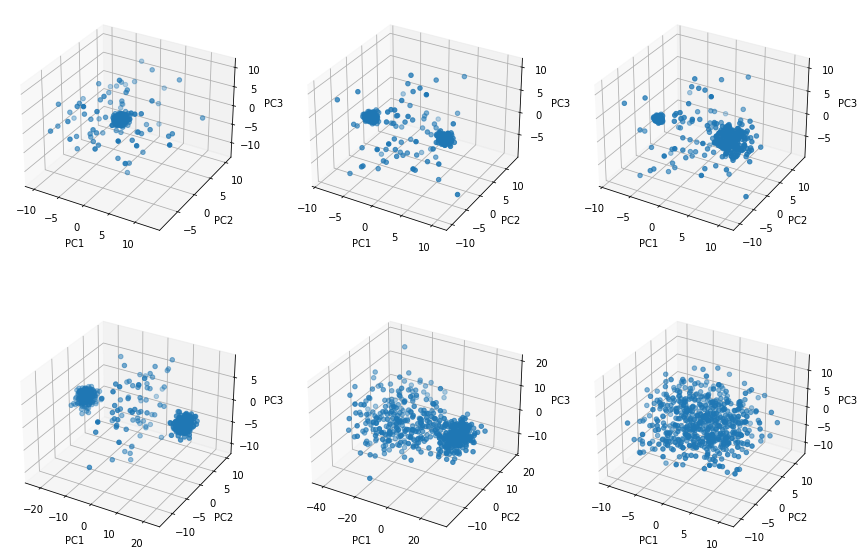

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 20))

outliers, ds = get_md_dataset()

for dataset_i, inliers in enumerate(ds):
    X = np.concatenate([inliers, outliers], axis=0)

    # 2D plot
    eigvals, eigvecs, explained = PCA(X)

    W = eigvecs[:, :3] # first 3 principle axis
    proj = X.dot(W)
    plx = proj[:, 0]
    ply = proj[:, 1]
    plz = proj[:, 2]
    
    # 2d scatterplot
    #ax2 = fig.add_subplot(1, len(ds), dataset_i+1)
    #ax2.set_aspect('equal')
    #ax2.set(xlabel='PC1', ylabel='PC2')
    #ax2.scatter(plx, ply, s=10)
    
    # 3d
    if (dataset_i < 3):
        ax3 = fig.add_subplot(2, len(ds), dataset_i+1, projection = '3d')
    else:
        ax3 = fig.add_subplot(1, len(ds), dataset_i+1-3, projection = '3d')
    ax3.set(xlabel='PC1', ylabel='PC2', zlabel='PC3')
    ax3.scatter(plx, ply, plz)

## 2. OD Models

In [5]:
# models

xx, yy = np.meshgrid(np.linspace(-7, 7, 75),
                     np.linspace(-7, 7, 75))

colors = np.array(['#67ae98', '#ff7f00'])

# demo anomaly detection on 2d dataset
def demo_anomalies_2d_data(detector, contour=True):
    fig = plt.figure(figsize=(30, 30))

    outliers, ds = get_2d_dataset()

    for dataset_i, inliers in enumerate(ds):
        X = np.concatenate([inliers, outliers], axis=0)

        if (dataset_i < 4):
            ax = fig.add_subplot(2, 4, dataset_i+1)
        elif (dataset_i < 8):
            ax = fig.add_subplot(1, 4, dataset_i+1-4)
        
        ax.set_aspect('equal')

        detector.fit(X)
        labels = detector.predict(X)

        if (contour):
            plot_space = np.c_[xx.ravel(), yy.ravel()]
            Z = detector.predict(plot_space)
            Z_contours = Z.reshape(xx.shape)
            ax.contour(xx, yy, Z_contours, levels=[0.5], linewidths=2, colors='black')

            Z = -1.0 * detector.decision_function(plot_space)
            Z_contours = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z_contours, levels=np.linspace(Z_contours.min(), Z_contours.max(), 10), cmap=plt.cm.Blues_r)

        ax.scatter(X[:, 0], X[:, 1], s=10, color=colors[labels])

    plt.show()
    
# demo anomaly detection on 2d dataset
def demo_anomalies_md_data(detector):
    fig = plt.figure(figsize=(30, 20))
    outliers, ds = get_md_dataset()

    for dataset_i, inliers in enumerate(ds):
        X = np.concatenate([inliers, outliers], axis=0)

        detector.fit(X)
        labels = detector.predict(X)

        # 2D plot
        eigvals, eigvecs, explained = PCA(X)

        W = eigvecs[:, :3] # first 3 principle axis
        proj = X.dot(W)
        plx = proj[:, 0]
        ply = proj[:, 1]
        plz = proj[:, 2]

        # 2d scatterplot
        #ax2 = fig.add_subplot(1, len(ds), dataset_i+1)
        #ax2.set_aspect('equal')
        #ax2.set(xlabel='PC1', ylabel='PC2')
        #ax2.scatter(plx, ply, s=10, color=colors[labels])

        # 3d
        if (dataset_i < 3):
            ax3 = fig.add_subplot(2, len(ds), dataset_i+1, projection = '3d')
        else:
            ax3 = fig.add_subplot(1, len(ds), dataset_i+1-3, projection = '3d')
        ax3.set(xlabel='PC1', ylabel='PC2', zlabel='PC3')
        ax3.scatter(plx, ply, plz, color=colors[labels])

    plt.show()

### a. Local Outlier Factor
- Define k-distance, k-reachability, local reachability density, local outlier factor following (Breunig et al., 2000) [4] :
- For $k \in \mathbb{N}$, distance (of chosen metric) between 2 datapoints $\mathbf{p}, \mathbf{q} \in \mathbf{X}$ is $d(\mathbf{p}, \mathbf{q}) \in \mathbb{R}$:
- Define k-distance:
$$\text{to find}\ \mathbf{o} \in \mathbf{X}\ \text{such that there exists}:\\
\begin{cases}
\text{at least}\ k\ &\ \text{objects}\ \mathbf{o}_i \in \mathbf{X} \backslash \left\{\mathbf{p}\right\}\ \ \ s.t.\ \ \ d(\mathbf{p}, \mathbf{o}) \geq d(\mathbf{p}, \mathbf{o}_i)\\
\text{at most}\ k-1\ &\ \text{objects}\ \mathbf{o}_j \in \mathbf{X} \backslash \{\mathbf{p}\}\ \ \ s.t.\ \ \ d(\mathbf{p}, \mathbf{o}) > d(\mathbf{p}, \mathbf{o}_j)
\end{cases}, \text{then}\ \ k{-}dist(\mathbf{p})=d(\mathbf{p}, \mathbf{o})$$
- Define k-neighbourhood (locality) as set of objects whose distance from $\mathbf{p}$ is less than or equal to k-distance of p: $$
\begin{aligned}
&\ \mathbf{N}_k(\mathbf{p})=\{\mathbf{q} \in \mathbf{X} \ |\ d(\mathbf{p}, \mathbf{q}) \leq k{-}dist(\mathbf{p}) \}
\end{aligned}$$
- Define k-reachability-distance of $\mathbf{o}$ w.r.t. $\mathbf{p}$ as: $$
\begin{aligned}
&\ reach{-}dist_k(\mathbf{o}, \mathbf{p}) = \max\left(k{-}dist(\mathbf{p}),\ d(\mathbf{o}, \mathbf{p})\right)
\end{aligned}$$
- Min-point $mp$ in place of $k$ is the minimum number of objects to apply across the algorithms.
- Define local reachability density as the inverse of average of reachability-distances of $mp-$ nearest neighbours of $\mathbf{p}$: $$
\begin{aligned}
&\ lrd_{mp}(\mathbf{p}) = \frac{1}{ | \mathbf{N}_{mp}(\mathbf{p}) | } \sum_{\mathbf{o} \in \mathbf{N}_{mp}(\mathbf{p})}{reach{-}dist_{mp}(\mathbf{p}, \mathbf{o})}
\end{aligned}$$
- Define the local outlier factor (LOF) of $\mathbf{p}$ as the ratio of average density of all $\mathbf{p}$'s neighbours and $\mathbf{p}$'s itself: $$
\begin{aligned}
&\ LOF_{mp}(\mathbf{p})=\frac{\frac{1}{| \mathbf{N}_{mp}(\mathbf{p}) |}\sum_{\mathbf{o} \in \mathbf{N}_{mp}(\mathbf{p})}{lrd_{mp}(\mathbf{o})}}{lrd_{mp}(\mathbf{p})}
\end{aligned} $$
- Applying the same metrics calculation on the entire population will bubble up the outliers, which have the highest scores.

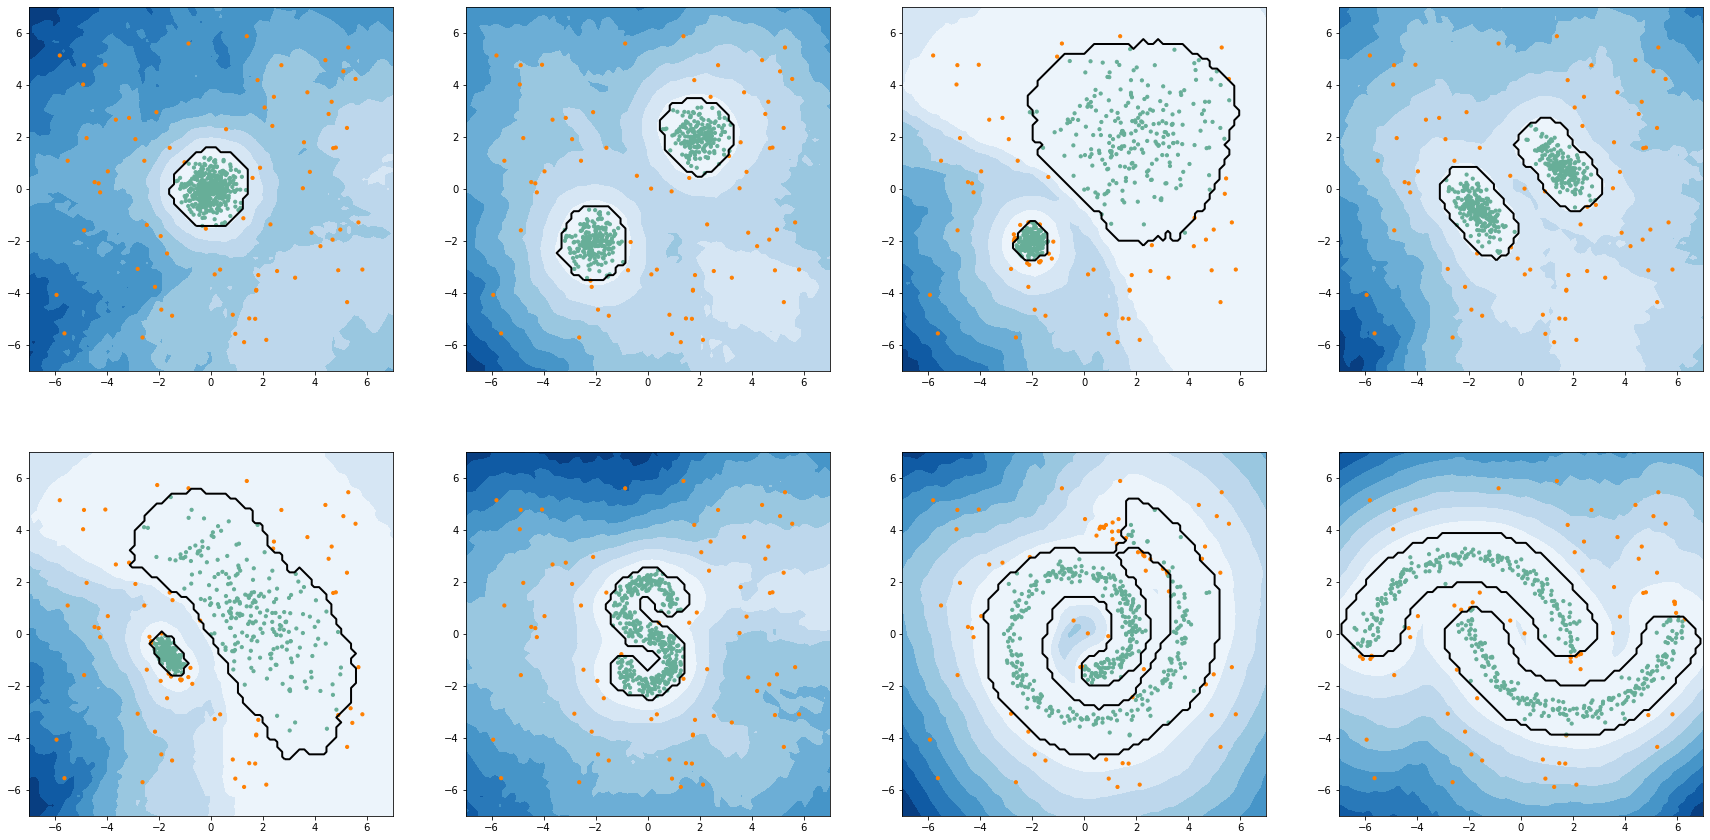

In [5]:
from pyod.models.lof import LOF
lof = LOF(contamination=outlier_percentage,n_neighbors=35, leaf_size=40, algorithm='auto', metric='minkowski', metric_params=None)

demo_anomalies_2d_data(lof)

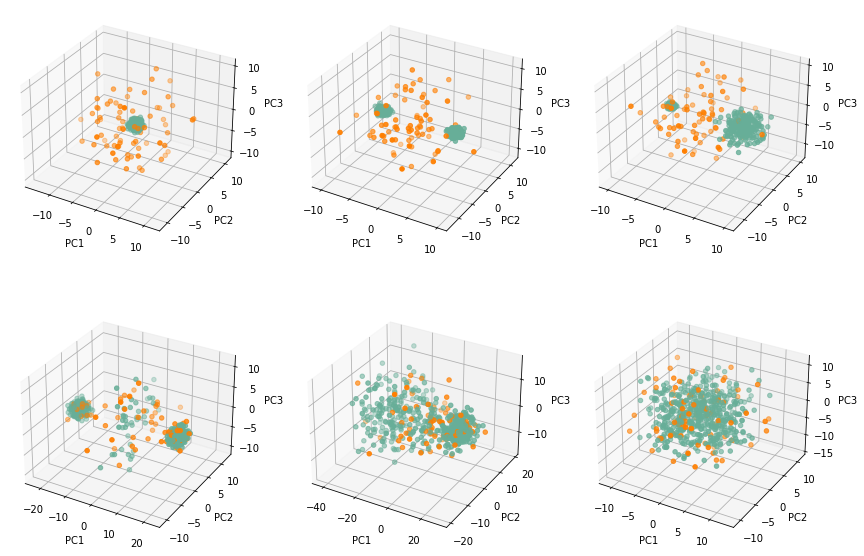

In [32]:
demo_anomalies_md_data(lof)

### b. k-Nearest Neighbour (Fast Outlier Detector)
- Use infinite space-filling Hilbert curve to approximate multi-dimensional distance, use k-nearest neighbour to estimate density (Angiulli & Pizzuti, 2002) [5]:
- Minkowski distance between two $d{-}dimensional$ datapoints $\mathbf{p}, \mathbf{q} \in \mathbb{R}^{d \times 1}$: $$d_t(\mathbf{p}, \mathbf{q}) = \begin{cases}
\left(\sum_{i=1}^d | p_i-q_i |^t \right)^{1/t} &, if\ 1 \leq t < \infty \\
\max_{1 \leq i \leq d}(|p_i-q_i|) &, if\ t= \infty 
\end{cases}$$
- With $k \in \mathbb{N}$ and $knn(\mathbf{p})$ - the set of k-nearest neighbours of $\mathbf{p}$, define an outlier weight for each datapoint $\mathbf{p}$ as total distance to its $knn(\mathbf{p})$: $$
\begin{aligned}
&\ \omega_k(\mathbf{p}) = \sum_{j=1}^k{d_t\left(\mathbf{p},\ knn_j(\mathbf{p})\right)}
\end{aligned},\ \ \ knn_j(\mathbf{p}) \in knn(\mathbf{p})$$
- As a result, determine a datapoint $\mathbf{p}$ as an the $m^{th}$ outlier w.r.t. $k$ and dataset $\mathbf{X} \in \mathbb{R}^{d \times n}$ if there exists $m-1$ datapoints $\mathbf{q}_{1 \leq i \leq m-1} \in \mathbf{X}\ \ s.t.\ \omega_k(\mathbf{q}_i) > \omega_k(\mathbf{p}),\ m \leq n$, i.e. all $\mathbf{q}_i$ and $\mathbf{p}$ form an outlying set of $m$ datapoints.
- The longer the distance a datapoint is required to reach all of its k-nearest neighbours, the more "singled-out" or "outlying" it is.

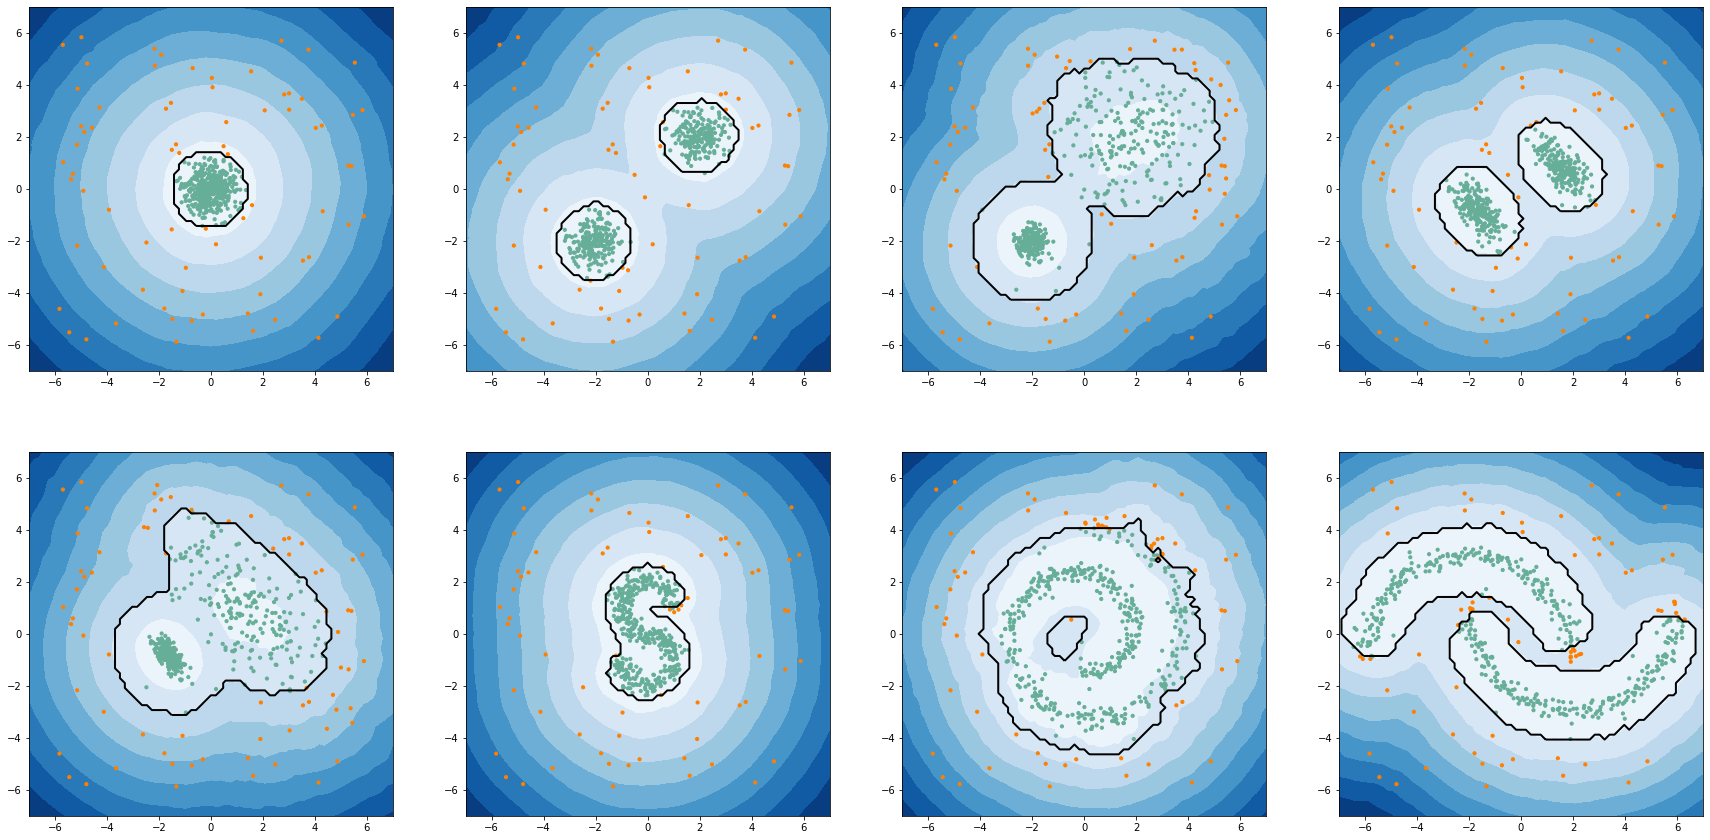

In [6]:
from pyod.models.knn import KNN
knn = KNN(contamination=outlier_percentage, n_neighbors=35, method='largest', leaf_size=40, radius=0.1, metric='minkowski', metric_params=None)

demo_anomalies_2d_data(knn)

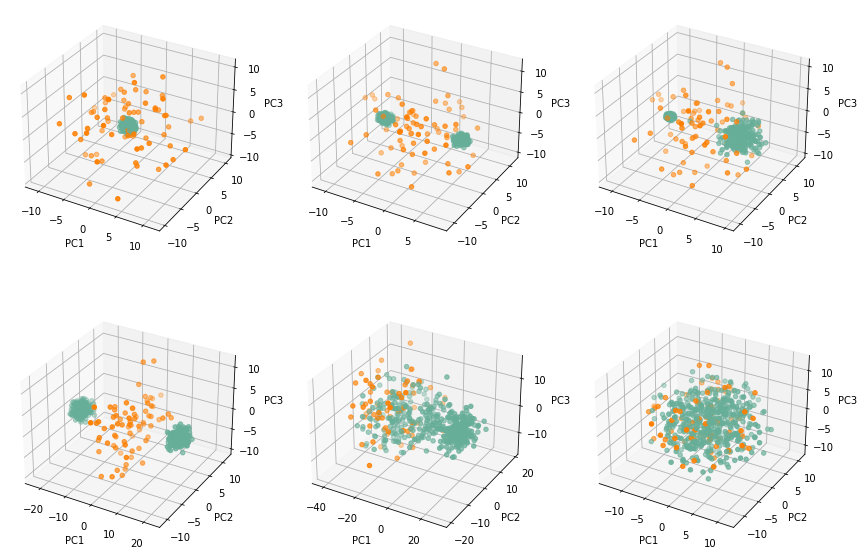

In [33]:
demo_anomalies_md_data(knn)

### c. Angle-based Outlier Detector
- Instead of relying on high-dimensional distance, weight anomaly score by using angle-based metric - weighted cosine (Kriegel et al., 2008) [6]:
- Construct an "angle" among 3 datapoints $A$, pair $(B,\ C)$, with $A,\ B,\ C \in \mathbf{X}$. Draw 2 difference vectors from $B$ and $C$ to $A$ : $\overline{AB} = B - A,\ \overline{AC} = C - A$.
- Angle $\theta$ between these 2 vectors derived from dot product: $
\cos(\theta)=\frac{\langle \overline{AB},\ \overline{AC} \rangle}{| \overline{AB} || \overline{AC} |}$
- Consider the norm-normalised cosine, or weighted cosine of this angle: $ncos(\theta)=\frac{\langle \overline{AB},\ \overline{AC} \rangle}{| \overline{AB} |^2| \overline{AC} |^2}$
- The formula for variances of weighted values used in this case is: $\frac{\sum{w_id_i^2}}{\sum{w_i}} - \left(\frac{\sum{w_id_i}}{\sum{w_i}}\right)^2$, which is used to formalise the angle-based outlying factor: $$
\begin{aligned}
ABOF_A
&= \text{Var}\left(\frac{\langle \overline{AB},\ \overline{AC} \rangle}{| \overline{AB} |^2| \overline{AC} |^2}\right)_{\forall B,C \in \mathbf{X}}\\
&= \frac{\sum_{B,C \in \mathbf{X}}{\frac{1}{| \overline{AB} || \overline{AC} |}} \cdot \left(\frac{\langle \overline{AB},\ \overline{AC} \rangle}{| \overline{AB} |^2| \overline{AC} |^2}\right)^2}{\sum_{B,C \in \mathbf{X}}{\frac{1}{| \overline{AB} || \overline{AC} |}}} - \left(\frac{\sum_{B,C \in \mathbf{X}}{\frac{1}{| \overline{AB} || \overline{AC} |}} \cdot \frac{\langle \overline{AB},\ \overline{AC} \rangle}{| \overline{AB} |^2| \overline{AC} |^2}}{\sum_{B,C \in \mathbf{X}}{\frac{1}{| \overline{AB} || \overline{AC} |}}}\right)^2
\end{aligned}$$
- The lower this variances, or angle-based outlying factor is, the more outlying a datapoint is.

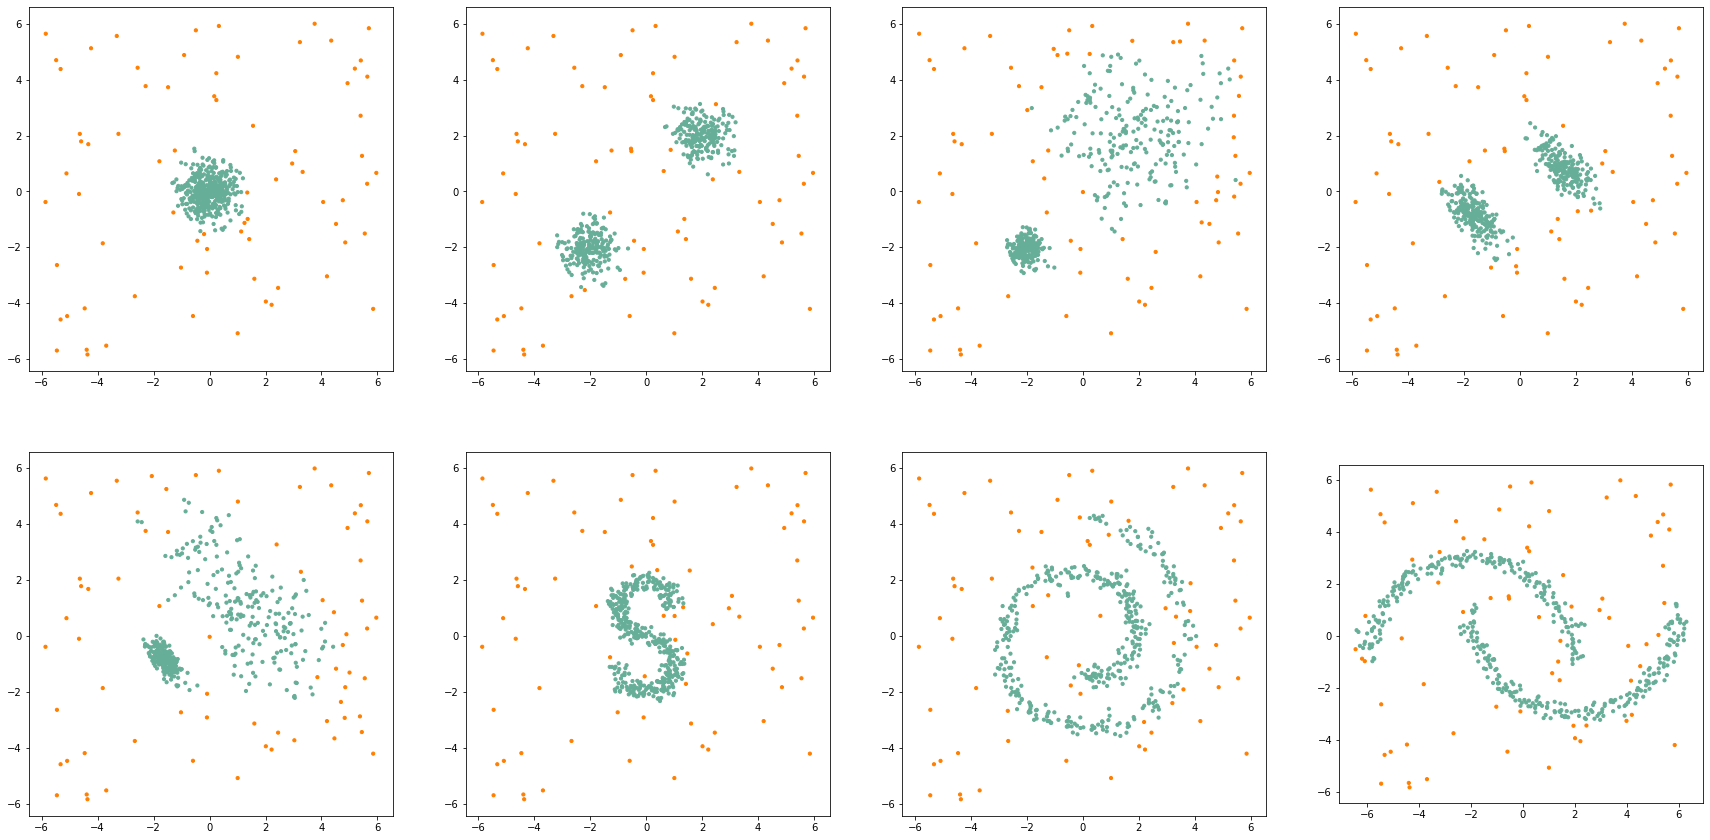

In [7]:
from pyod.models.abod import ABOD
abod = ABOD(contamination=outlier_percentage, n_neighbors=35, method='fast')

demo_anomalies_2d_data(abod, contour=False)

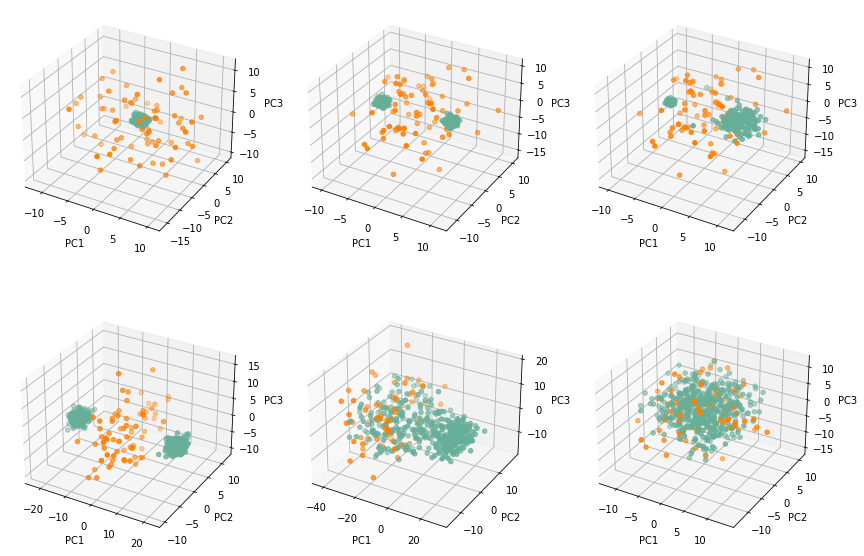

In [34]:
demo_anomalies_md_data(abod)

### d. One-class Support Vector Machine
- Combine soft-margin SVM, reproducing kernel Hilbert space (Gaussian kernel) to derive the one-class support vector, which separate datapoints from origin with a separation error from soft-margin (which are outliers) (Schölkopf et al., 2001) [7].

- Gaussian kernel $k(\mathbf{x}_i, \mathbf{x}_j)=\exp\left(-\frac{\| \mathbf{x}_i - \mathbf{x}_j \|^2}{c}\right) \in \mathbb{R}$. As a result, we can see $k(\mathbf{x}_i, \cdot)$ as a function. In fact it is a Gaussian distribution of mean $\mathbf{x}_i$.

- Define feature mapping, or feature datapoint $\Phi : \mathbb{R}^d \mapsto \mathcal{H}: \Phi(\mathbf{x}) = k(\mathbf{x}, \cdot)$. $\Phi$ forms a Hilbert space $\mathcal{H}$ with inner product as the Gaussian kernel itself. The dot product between $\mathbf{x}_i$ and $\mathbf{x}_j$ evaluates as: $\langle \Phi(\mathbf{x}_i),\ \Phi(\mathbf{x}_j) \rangle_{\mathcal{H}} = k(\mathbf{x}_i,\ \mathbf{x}_j)$. This is a reproducing kernel Hilbert space (RKHS) (Hofmann et al., 2008) [8].

- Relating directly to the linear space, since this kernel always produce a positive dot product $k(\mathbf{x}_i, \mathbf{x}_j) = \langle \Phi(\mathbf{x}_i),\ \Phi(\mathbf{x}_j) \rangle_{\mathcal{H}} > 0$, all of its elements belongs to the same orthant.

- Hyperplane $\langle w,\ \Phi(\mathbf{x}) \rangle_{\mathcal{H}}$ will always put feature datapoints to one half-space as $p \rightarrow 0$, therefore it's always possible to "push" this hyperplane "away from" the origin, and as "close" to the images $\Phi(\mathbf{x})$ as possible. Note that the original space's origin doesn't map to the origin of feature space $\mathcal{H}$, but in fact a datapoint $\mathbf{o}$ with its norm $\lim(|\mathbf{o}|) \rightarrow \infty$. Likely-outliers in the data space $\mathbb{R}^d$  end up closer to "origin" in the feature space $\mathcal{H}$.

- In this RKHS $\mathcal{H}$, characterise soft-margin support vector machine hyperplane: $$
\underset{w \in \mathcal{H},\ \mathbf{\xi} \in \mathbb{R}^d,\ p \in \mathbb{R}}{\min}\frac{1}{2}|w|^2 + \frac{1}{\nu d}\sum_{i=0}^n{\xi_i}-p\ ,\ \ \ s.t. \begin{cases}
\langle w,\ \Phi(\mathbf{x}_i) \rangle_{\mathcal{H}} \geq p - \xi_i\\
\xi_i \geq 0, \ \forall \ 1 \leq i \leq n\\
\nu \in (0,1]
\end{cases}$$.

- Preset hyperparameter $\nu$ directly relates to the probability of outliers. For scalable $w$ without losing any characteristics, $-p$ signifies the margin and $\xi_i$ denotes soft-margin, to allow for outliers. These will be controlled by the support vectors after solving the optimization problem.

- The decision function for $\mathbf{x}$ is given by: $$
f(\mathbf{x})=\textbf{sgn}\left(\langle w,\ \Phi(\mathbf{x}) \rangle_{\mathcal{H}} -p\right)
$$

- After solving for gradient of the Lagrangian being 0, using KKT condition for dual problem, obtaining the dot product can be calculated by using kernel trick (Hofmann et al., 2008) [8], and classification step can be expressed purely in dot product form: $$\begin{cases}
\text{dot product} &: \langle w,\ \Phi(\mathbf{x}_i) \rangle_{\mathcal{H}} = \sum_j{\alpha_j \cdot k(\mathbf{x}_j, \mathbf{x}_i)}\\
\text{classify}&: f(\mathbf{x})=\textbf{sgn}\left(\sum_j{\alpha_j \cdot k(\mathbf{x}_j, \mathbf{x})} -p\right)
\end{cases},\ \ \text{with j is support vector index}\\
$$

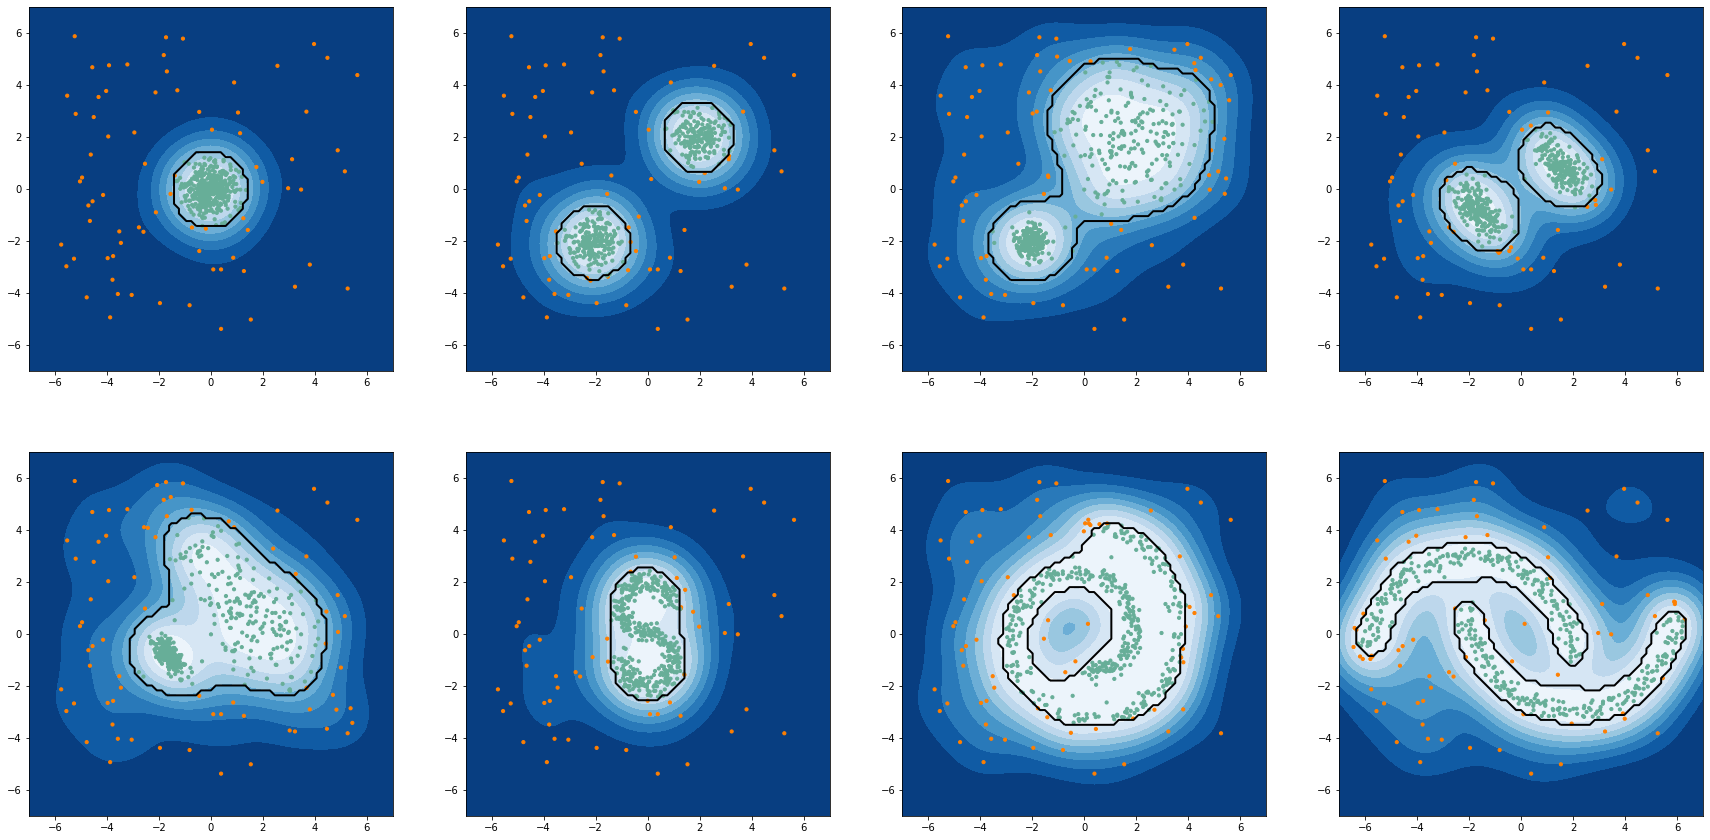

In [8]:
from pyod.models.ocsvm import OCSVM
ocsvm = OCSVM(contamination=outlier_percentage, kernel="rbf", gamma='auto')

demo_anomalies_2d_data(ocsvm)

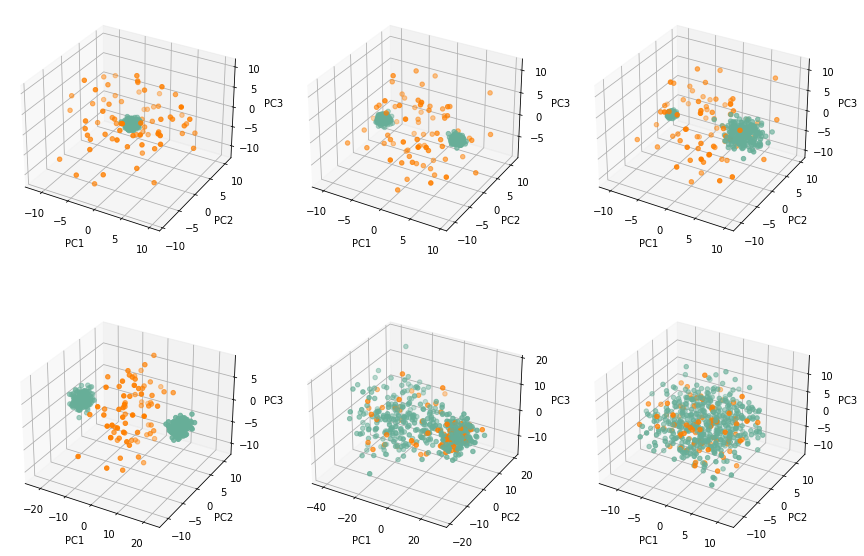

In [35]:
demo_anomalies_md_data(ocsvm)

### e. Lightweight Online Detector
- Continuously project the datapoint onto 1-D axis and analyse the histogram of the projections to derive local density estimation, which ensembles into a total density estimation to predict outliers (Pevný, 2015) [9]:
  - Construct randomised $k$ (large) projection axis unit vectors - columns of matrix $[\mathbf{w}_1, \mathbf{w}_2, ..., \mathbf{w}_k] = \mathbf{W} \in \mathbb{R}^{d \times k} $, as "scopes" to observe this dataset.
  
  - Consider a matrix of histogram: $\mathbf{H} \in \mathbb{R}^{k \times \ell}$. Columns $\ell \leq n$ signify projection value ranges. Row $\mathbf{h}_{\bar{i}}$ is a discrete histogram of projections of $\mathbf{X}$ onto axis $\mathbf{w}_i,\ 1 \leq i \leq k$, modeling the probability density of $\mathbf{X}$ w.r.t. $\mathbf{w}_i$.
  
  - Histogram $\mathbf{h}_{\bar{i}}$ (row $i^{th}$ of matrix $\mathbf{H}$) w.r.t. projection $\mathbf{w}_i$, to consist of pairs $(z, m)$: for each datapoint $\mathbf{x}_j \in \mathbf{X}$, obtain projection $z = \mathbf{w}_i^T\mathbf{x}_j$. Select a bandwidth $c$ such that if this $z$ has been recorded by the histogram $\mathbf{h}_{\bar{i}}$ prior (consider recorded $z_p \in [z-c, z+c]$ when recording histogram), increase the density count $m_p = m_p + 1$ at this value, otherwise we put this new value $z$ into the histogram with a new density $m = 1$.
  
  - After using projection matrix $\mathbf{W}$ to obtain histogram matrix $\mathbf{H}$ modeling the probability density of $\mathbf{X}$ w.r.t. projection matrix $\mathbf{W}$. For any observation $\mathbf{x}_0$, obtain the probability score $\hat{p}_i$, sampled from histogram $(\mathbf{h}_{\bar{i}},\ \mathbf{w}_i)$ pair: $$ 
  \hat{p}_i(\mathbf{x}_0) = \begin{cases}
    \frac{z_pm_p+z_{p+1}m_{p+1}}{2\left(\sum_{i=1}^{\ell}m_i\right)(z_{p+1}-z_p)} &, \text{if}\ \ \exists{p}: z_p < \mathbf{w}_i^T\mathbf{x}_0 \leq z_{p+1},\ (z,m) \in \mathbf{h}_{\bar{i}} \\
    -\infty &, \text{otherwise}
    \end{cases}
  $$
  
  - Obtain joint probability of projections of $\mathbf{x}_0$ across all $\mathbf{w}_i$: $$ \begin{aligned}
  P(\mathbf{x}_0)
  &= -\frac{1}{k}\sum_{i=1}^{k}\log\left(\hat{p}_i(\mathbf{w}_i^T\mathbf{x}_0)\right)\\
  &= -\log\left(\prod_{i=1}^{k}\hat{p}_i(\mathbf{w}_i^T\mathbf{x}_0)\right)^{\frac{1}{k}}\\
  & \sim -\log\left(P(\mathbf{w}_1^T\mathbf{x}_0, \mathbf{w}_2^T\mathbf{x}_0, ..., \mathbf{w}_k^T\mathbf{x}_0)\right)
  \end{aligned}$$. Note that the last line if to explain it being equivalent to the overall probability, not for calculation.
  
  - The lower the probability score $P$, the more outlying the datapoint will be.

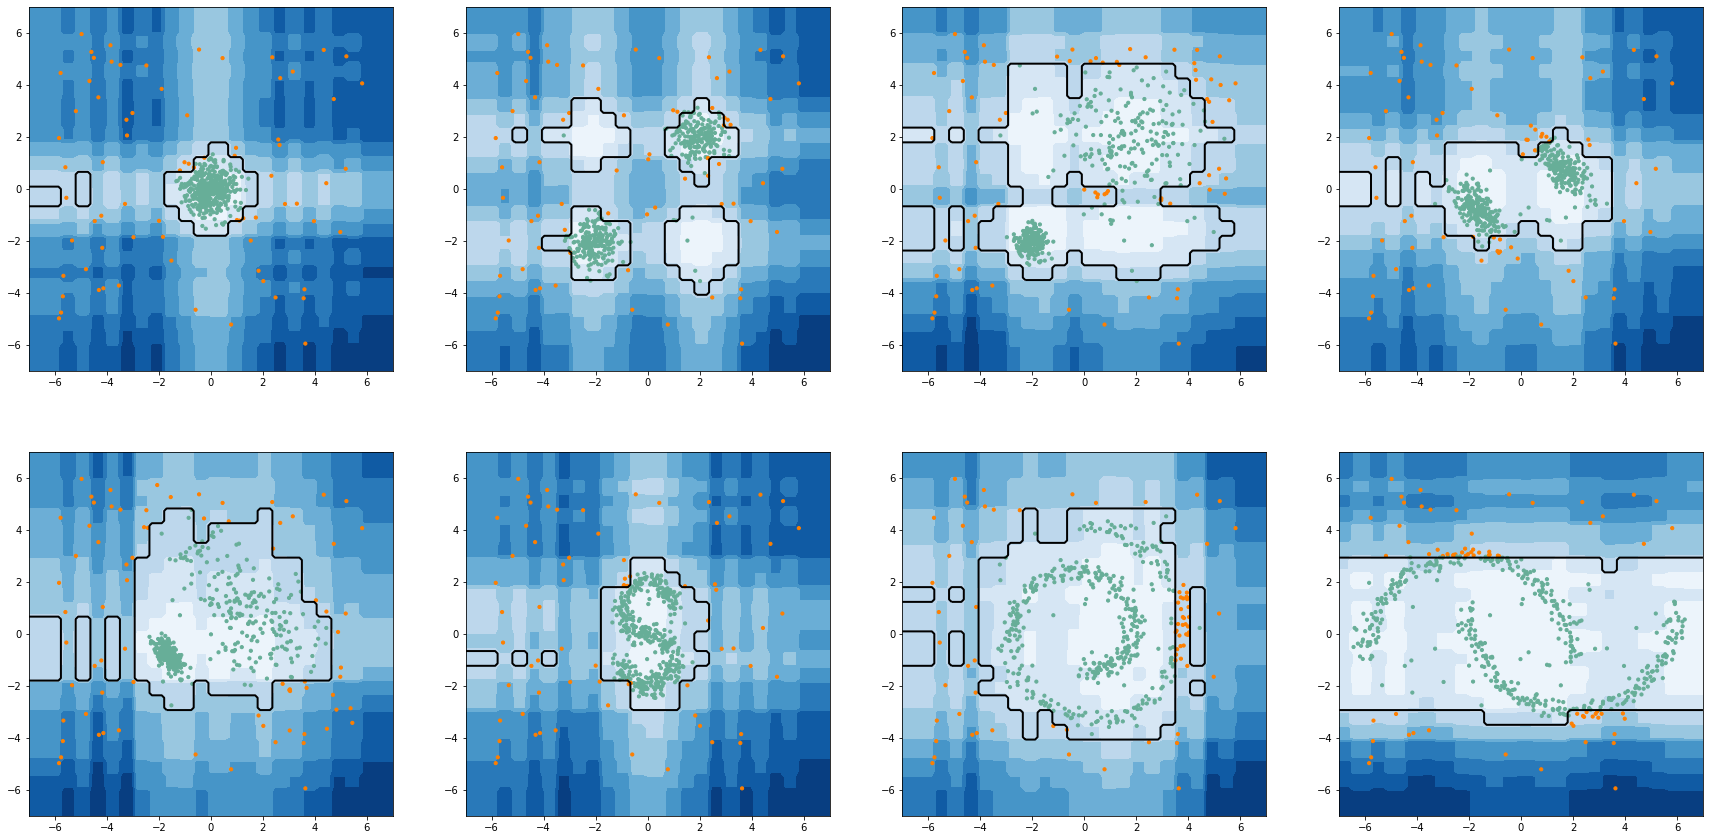

In [9]:
from pyod.models.loda import LODA
loda = LODA(contamination=outlier_percentage, n_bins=20, n_random_cuts=400)

demo_anomalies_2d_data(loda)

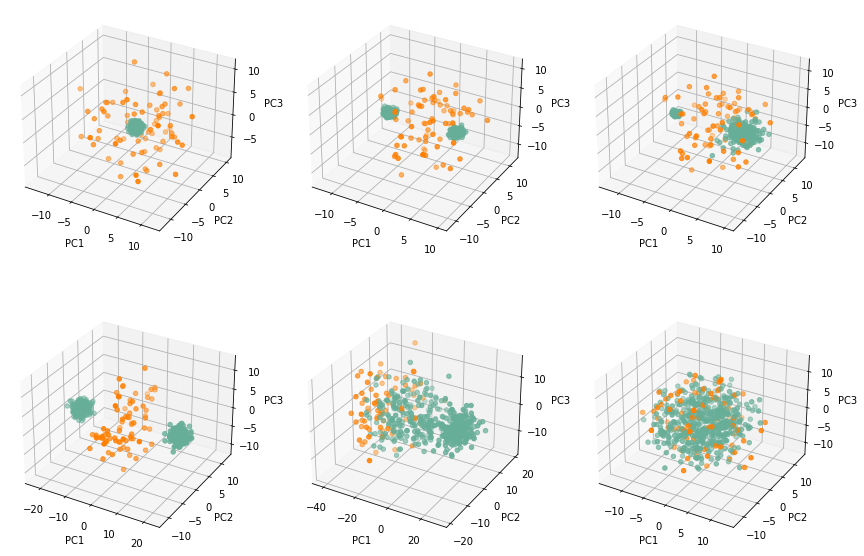

In [36]:
demo_anomalies_md_data(loda)

### f. Isolation Forest
- Grow a random-decision binary tree by choosing a feature and a decision split, ensemble a random forest which isolate outliers more easily than nominal datapoint (Liu et al., 2008) [10]:
  - Define an O(1) $p{-}test(.)$ operation, which takes features $q: 1 \leq q \leq d$, and value $p \in \mathbb{R}$, then compares each datapoint's feature $\mathbf{x}_{i_q}$ or $\mathbf{X}_{qi}$ with $p$.
  
  - Grow an isolation tree or iTree (binary tree) recursively: randomly slect $q$ and $p$, then split the dataset using this $p{-}test(.)$ - O(n) operation: datapoint $\mathbf{x}_i$ satistfies $\mathbf{x}_{i_q} \leq p$ form a left-subtree, the rest of the datapoints from a right-subtree, until either reaching a heigh limit, sub-tree is a leaf node, or all data in a subtre are identical.

  - Define path length $h(\mathbf{x})$. An iTree by itself is not a good score assignment, however an ensemble (iForest), the anomalies are often splitted early and have shorter path length $h(\mathbf{x})$.
  
  - Define the normalised average path length $\bar{h}(\mathbf{x})$ by normalising the expectation of $h(\mathbf{x})$ over the average path length of unsuccessful searches $c(n)$ in a binary-search tree of $n$ datapoints: $$ \begin{aligned}
    c(n) &= 2H(n-1) - \frac{2n-1}{n} ,\ \text{harmonic number}: H(k) \sim ln(k) + \epsilon\\
    \bar{h}(\mathbf{x}) &= \frac{E\left[h(\mathbf{x})\right]}{c(n)} ,\ \text{expectation}\ E(\cdot)\ \text{from all iTrees}
  \end{aligned} $$
  - Define the anomaly score by raising the normalised average path length $\bar{h}(\mathbf{x})$ to an exponential decay $2^{-x}$: $$
    s(\mathbf{x}, n) = 2^{-\bar{h}(\mathbf{x})} = 2^{-E\left[h(\mathbf{x})\right]/c(n)}
  $$
  - From this exponential decay: $$ \begin{cases}
     \underset{E\left[h(\mathbf{x})\right] \to 0}{\lim}s(\mathbf{x}, n) = 1 &,\ \ \bar{h}(\mathbf{x}) \to 0\\
     \underset{E\left[h(\mathbf{x})\right] \to c(n)}{\lim}s(\mathbf{x}, n) = 0.5 &,\ \ \bar{h}(\mathbf{x}) \to -1\\
     \underset{E\left[h(\mathbf{x})\right] \to n-1}{\lim}s(\mathbf{x}, n) = 1 &,\ \ \bar{h}(\mathbf{x}) \to -\frac{n-1}{c(n)}\\
  \end{cases} $$
  
  - As path length starts from 0 - small - easy to separate - most likely an anomaly, $\bar{h}(\mathbf{x}) = 0$ , value of $s(\mathbf{x}, n)$ starts from 1, exponentially decaying down to 0, where $E\left[h(\mathbf{x})\right] = n-1$ - expected path length is maximised - the lowest possible leaf - hardest to separate - most likely a nominal datapoint. The middle value is where the separation of anomalies with nominal datapoints is, with expected path length being approximated to unsuccessful BST searches.

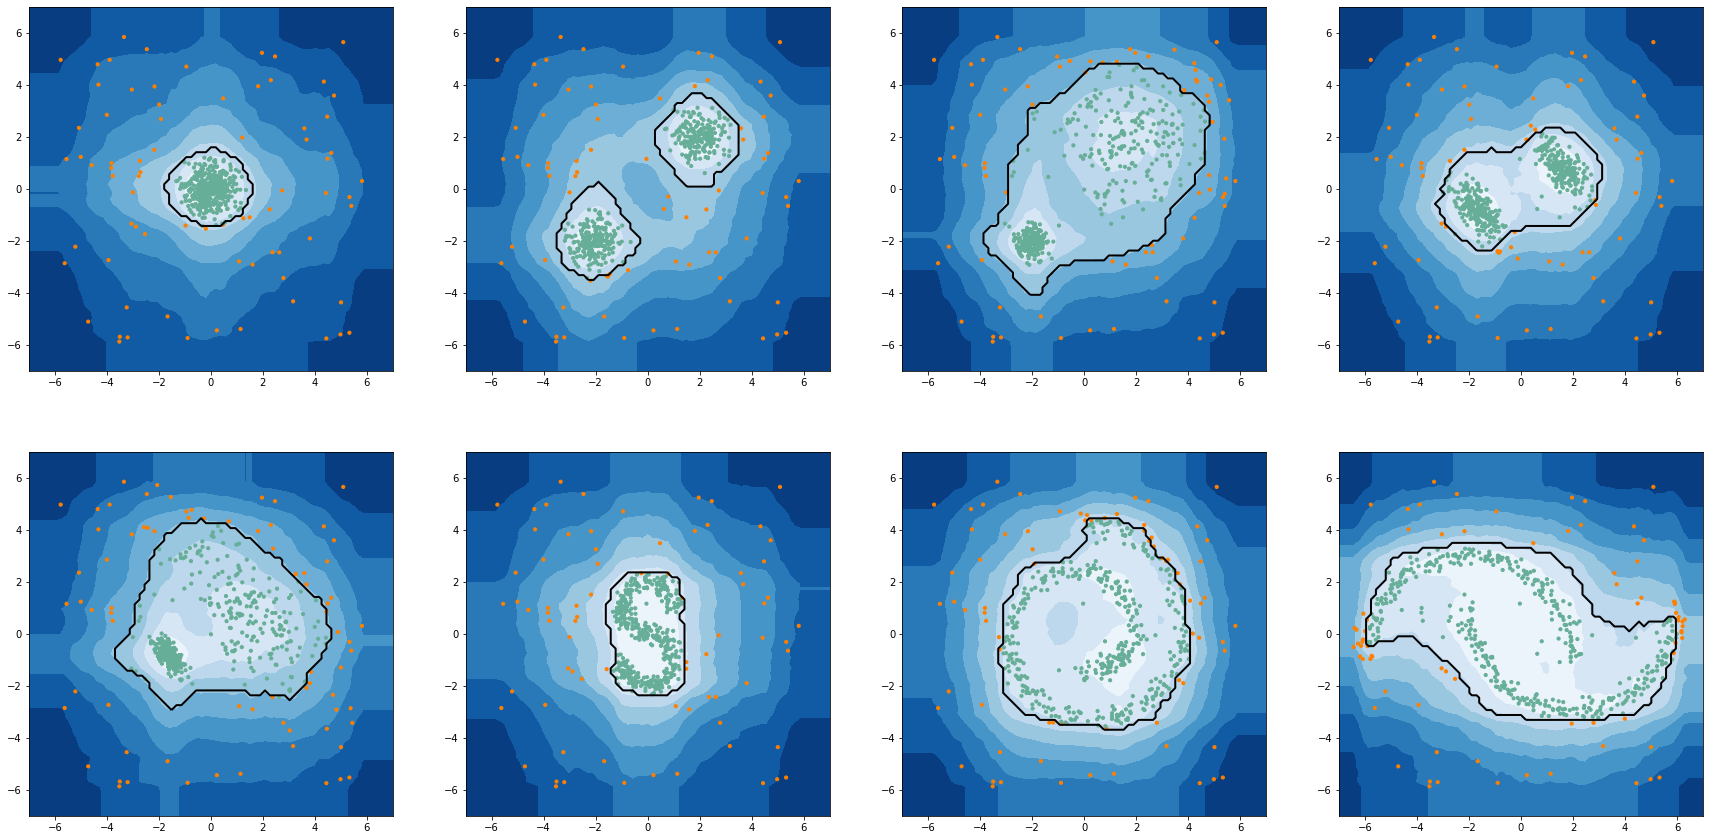

In [10]:
demo_anomalies_2d_data(iforest)

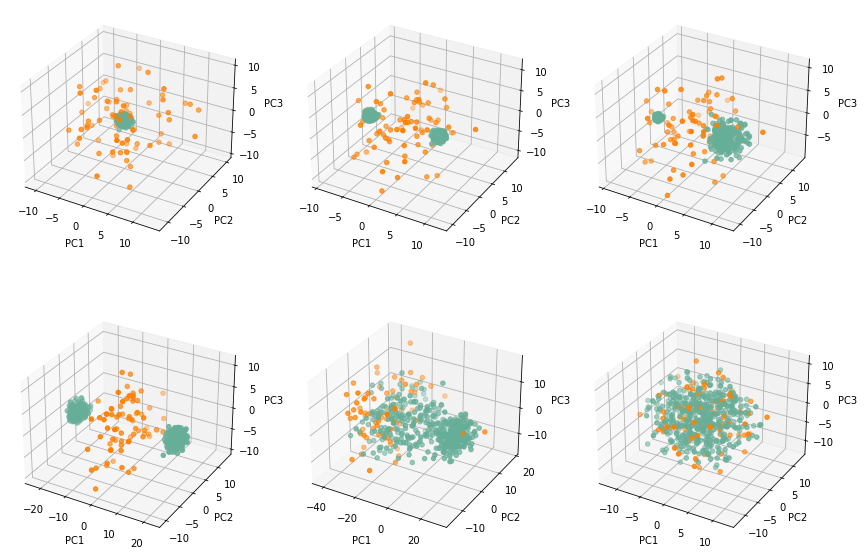

In [37]:
from pyod.models.iforest import IForest
iforest = IForest(contamination=outlier_percentage, n_estimators=400, max_samples='auto')

demo_anomalies_md_data(iforest)

### h. PCA-based anomaly detection
- Perform PCA on dataset, then use the first few and last few principle components to calculate metrics which are based on Malanobis distance, to consider anomalies (Shyu et al., 2003) [11]:
- Feature-vectors as columns matrix $[\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_d] = \mathbf{X} \in \mathbb{R}^{n \times d}$. Columns $\mathbf{x}_i \in \mathbb{R}^{n \times 1}, 1 \leq i \leq d$ of $\mathbf{X}$ are features. Rows, denoting as row-vector $\mathbf{x}_{\vec{j}}^T \in \mathbb{R}^{1 \times d}, 1 \leq j \leq n$, are observations. Denote observation in column-vector form as $\mathbf{x}_{\vec{j}}$

- Obtain d mean-values of these features: $[\mu_1, \mu_2, ..., \mu_d] = \mathbf{\bar{\mu}} \in \mathbb{R}^{1 \times d}$.

- From PCA, obtain $p \leq d$ eigenvector-eigenvalue pairs of the covariance matrix $\mathbf{S}$: $(\mathbf{v}_1, \lambda_1), (\mathbf{v}_2, \lambda_2), ..., (\mathbf{v}_p, \lambda_p)$. The principle score $y_i$ of feature $1 \leq i \leq p \leq d$ of any observation $\mathbf{x} \in \mathbb{R}^{d \times 1}$ (note that these are column-vectors, equivalent to column-form $\mathbf{x}_{\vec{j}}$, or row-form $\mathbf{x}_{\vec{j}}^T$ in our dataset matrix), w.r.t. dataset $\mathbf{X}$, with the $i^{th}$ eigenvector $\mathbf{v}_i$: $$ \begin{aligned}
y_i = \mathbf{v}_i^T\left(\mathbf{x} - \mathbf{\bar{\mu}}^T\right)
\end{aligned}$$

- Sum of these $p$ principle scores are exactly the squared Mahalanobis distance of observation $\mathbf{x}$ towards the population $\mathbf{X}$'s centroid (sampled mean, using this method): $$ \begin{aligned}
\sum_{i}^p\frac{y_i^2}{\lambda_i}
    &= \frac{\left(\mathbf{x} - \mathbf{\bar{\mu}}^T\right)^T\mathbf{v}_i\mathbf{v}_i^T\left(\mathbf{x} - \mathbf{\bar{\mu}}^T\right)}{\lambda_i}\\
    &= \left(\mathbf{x} - \mathbf{\bar{\mu}}^T\right)^T\mathbf{V}\Lambda^{-1}\mathbf{V}^T\left(\mathbf{x} - \mathbf{\bar{\mu}}^T\right)\\
    &= \left(\mathbf{x} - \mathbf{\bar{\mu}}^T\right)^T\mathbf{S}^{-1}\left(\mathbf{x} - \mathbf{\bar{\mu}}^T\right)
\end{aligned} $$. Where $\mathbf{S} = \mathbf{\bar{X}}^T\mathbf{\bar{X}}$ is the covariance matrix of the original matrix $\mathbf{X}$ ($\mathbf{\bar{X}}$ is the mean-centered of $\mathbf{X}$).

- Two metrics will be considered: sum of the first $q$, and sum of the last $r$ principle scores: major (components) metrics and minor (components) metrics. For each observation $\mathbf{x} \in \mathbb{R}^{d \times 1}$, with $[y_1, y_2, ..., y_p]$ being the principle scores of $\mathbf{x}$ w.r.t. $\mathbf{X}$, calculate: $$ \begin{cases}
\text{major_metrics} &= \sum_{i=1}^q\frac{y_i^2}{\lambda_i} &, 1 \leq q \leq p\\
\text{minor_metrics} &= \sum_{i=p-r+1}^p\frac{y_i^2}{\lambda_i} &, 1 \leq r \leq p\\
\end{cases},\ \ \ \ \text{q, r independent} $$. $\text{major_metrics}$ siginifies how much variation in $\mathbf{x}$ would be distributed over the first principle components, and likewise, $\text{minor_metrics}$ over the last principle components.

- The anomalies will be determined by quantitation, the higher $\text{major_metrics}$ and $\text{minor_metrics}$ are, the more anomalous the datapoint will likely be, and we pick so that they add up to preset percentage of anomalies.

(500, 2)
==> X
(500, 2)
==> PCA
[1597.82616734 1225.2888682 ]
[0.5659798298070258, 0.43402017019297434]
==> feature means
[[-0.05247142]
 [ 0.01310307]]
==> features
(2, 500)
==> PC-projected values
(2, 500)
==> major
1
0.00942474242737934
==> minor
0
0.006793777498290011
(500, 2)
==> X
(500, 2)
==> PCA
[4747.98409312 1535.15113147]
[0.7556711615142638, 0.24432883848573625]
==> feature means
[[-0.04847142]
 [ 0.01710307]]
==> features
(2, 500)
==> PC-projected values
(2, 500)
==> major
1
0.0033295344413808298
==> minor
0
0.007603896225721289
(500, 2)
==> X
(500, 2)
==> PCA
[5052.52208459 1924.77067509]
[0.7241378939674891, 0.27586210603251105]
==> feature means
[[-0.07058599]
 [ 0.03669876]]
==> features
(2, 500)
==> PC-projected values
(2, 500)
==> major
1
0.004408925487109519
==> minor
0
0.00766570268514445
(500, 2)
==> X
(500, 2)
==> PCA
[2548.92827789 1690.07866203]
[0.6013031622763992, 0.39869683772360087]
==> feature means
[[-0.04636499]
 [ 0.03481833]]
==> features
(2, 500)
==> 

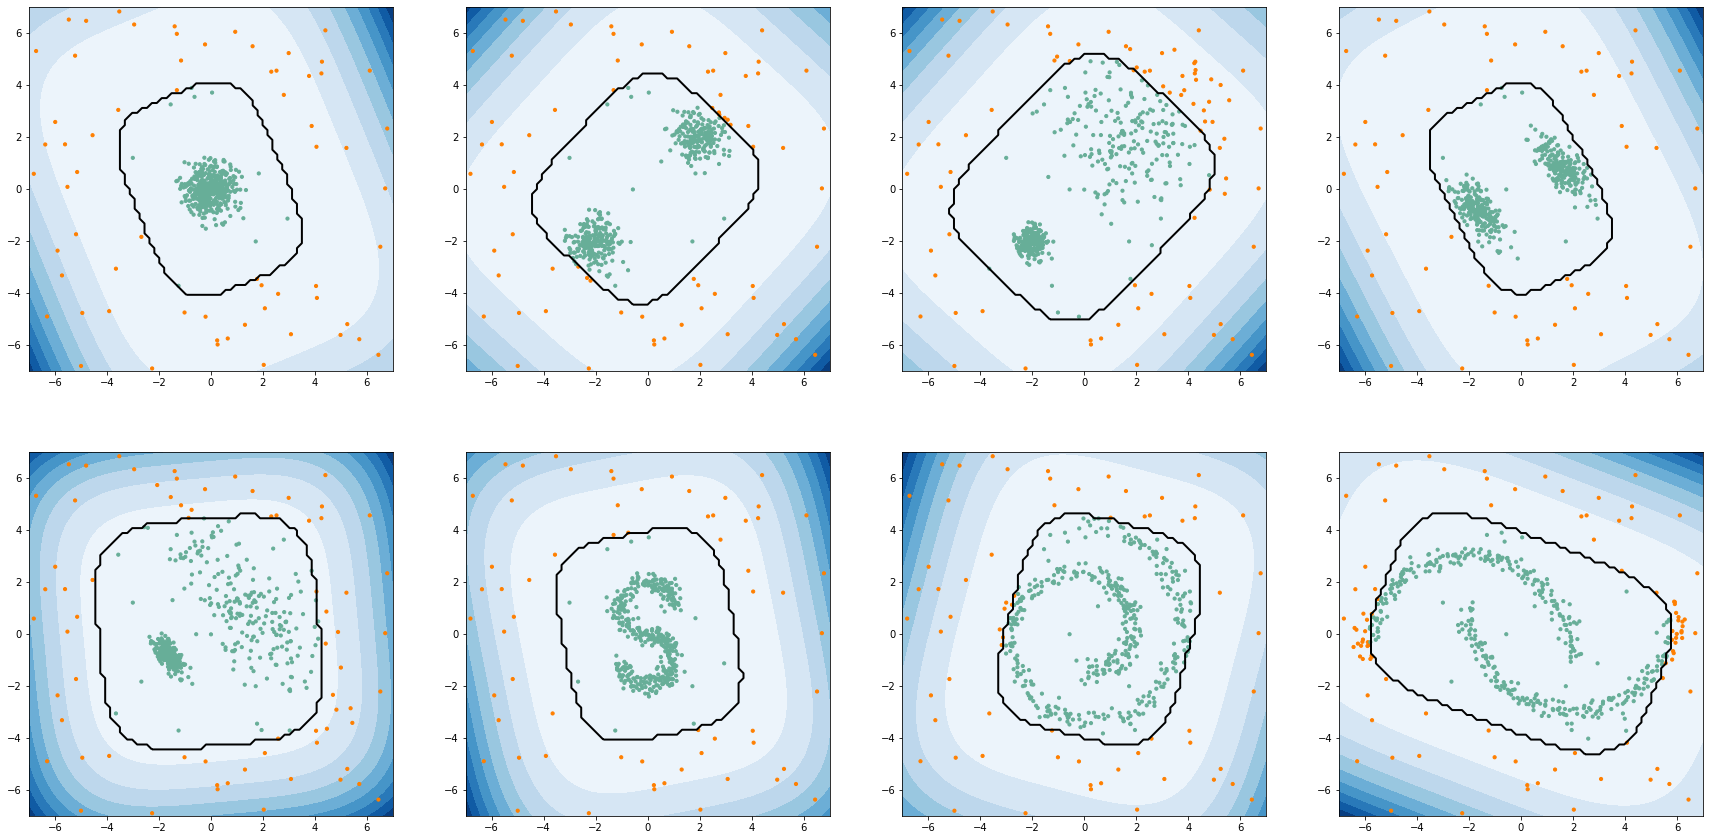

In [6]:
from AD.PCAAD import PCAAD
pcaad = PCAAD(contamination=0.15)

demo_anomalies_2d_data(pcaad)

(500, 10)
==> X
(500, 10)
==> PCA
[2214.06477641 1885.04138816 1636.77520583 1412.06395133 1378.10477484
 1123.72187507 1043.63797604  958.48625792  862.17493764  742.0132311 ]
[0.16702253198478603, 0.14220197570624768, 0.12347350541875766, 0.10652194957865044, 0.10396016922697422, 0.08477027177411464, 0.0787289780731897, 0.07230538301136462, 0.06503994039962291, 0.055975294826292134]
==> feature means
[[-0.11788747]
 [-0.12078337]
 [ 0.06806139]
 [-0.00607516]
 [ 0.0190357 ]
 [-0.05357265]
 [ 0.00096586]
 [ 0.0532235 ]
 [-0.04076262]
 [ 0.12202079]]
==> features
(10, 500)
==> PC-projected values
(10, 500)
==> major
4
0.04624717987897155
==> minor
0
0.10909733380791652
(500, 10)
==> X
(500, 10)
==> PCA
[18374.12000583  2208.63549887  1884.22342131  1598.25009036
  1393.40959262  1178.16813526  1118.07025351   976.31962858
   870.96772642   799.06212148]
[0.6043874585585526, 0.07264955250214943, 0.06197853309991102, 0.052571895140954644, 0.045833992710914755, 0.03875396725399921, 0.0367

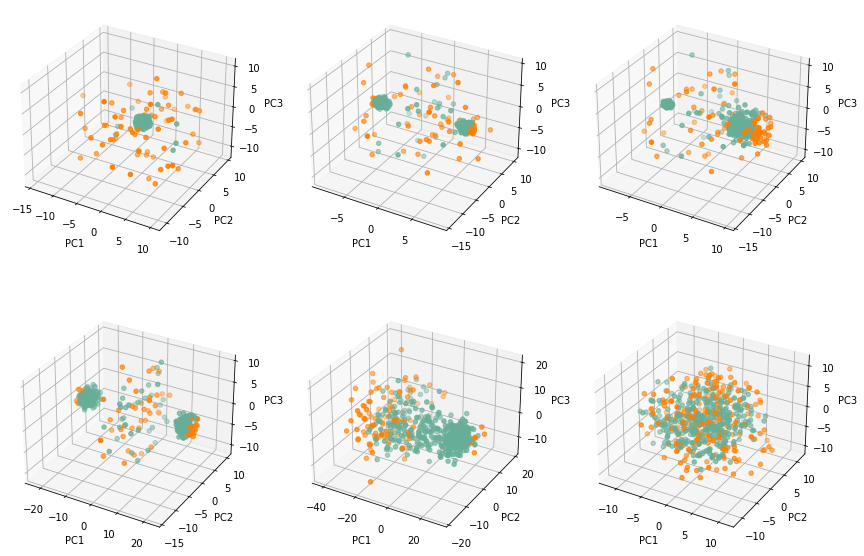

In [7]:
demo_anomalies_md_data(pcaad)

## 3. Statistics models for OD

In [41]:
def demo_probability_2d_data(model):
    fig = plt.figure(figsize=(30, 30))
    outliers, ds = get_2d_dataset()

    for dataset_i, inliers in enumerate(ds):
        X = np.concatenate([inliers, outliers], axis=0)
        
        if (dataset_i < 4):
            ax = fig.add_subplot(2, 4, dataset_i+1)
        elif (dataset_i < 8):
            ax = fig.add_subplot(1, 4, dataset_i+1-4)

        ax.set_aspect('equal')

        model.fit(X)

        scores = model.score_samples(X)
        threshold = np.quantile(scores, 0.15) # 15% outliers
        labels = np.zeros(X.shape[0], dtype=int)
        labels[np.where(scores < threshold)] = 1

        plot_space = np.c_[xx.ravel(), yy.ravel()]
        Z = model.score_samples(plot_space)
        Z_labels = np.zeros(plot_space.shape[0], dtype=int)
        Z_labels[np.where(Z < threshold)] = 1
        Z_contours = Z_labels.reshape(xx.shape)
        ax.contour(xx, yy, Z_contours, levels=[0.5], linewidths=2, colors='black')

        Z = model.score_samples(plot_space)
        Z_contours = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z_contours, levels=np.linspace(Z_contours.min(), Z_contours.max(), 10), cmap=plt.cm.Blues_r)
        ax.scatter(X[:, 0], X[:, 1], s=10, color=colors[labels])

    plt.show()
    
def demo_probability_md_data(model):
    fig = plt.figure(figsize=(30, 20))
    outliers, ds = get_md_dataset()

    for dataset_i, inliers in enumerate(ds):
        X = np.concatenate([inliers, outliers], axis=0)

        model.fit(X)
        scores = model.score_samples(X)
        threshold = np.quantile(scores, 0.15) # 15% outliers
        labels = np.zeros(X.shape[0], dtype=int)
        labels[np.where(scores < threshold)] = 1

        # 2D plot
        eigvals, eigvecs, explained = PCA(X)

        W = eigvecs[:, :3] # first 3 principle axis
        proj = X.dot(W)
        plx = proj[:, 0]
        ply = proj[:, 1]
        plz = proj[:, 2]

        # 2d scatterplot
        #ax2 = fig.add_subplot(1, len(ds), dataset_i+1)
        #ax2.set_aspect('equal')
        #ax2.set(xlabel='PC1', ylabel='PC2')
        #ax2.scatter(plx, ply, s=10, color=colors[labels])

        # 3d
        if (dataset_i < 3):
            ax3 = fig.add_subplot(2, len(ds), dataset_i+1, projection = '3d')
        else:
            ax3 = fig.add_subplot(1, len(ds), dataset_i+1-3, projection = '3d')
        ax3.set(xlabel='PC1', ylabel='PC2', zlabel='PC3')
        ax3.scatter(plx, ply, plz, color=colors[labels])

    plt.show()

### a. Gaussian Mixture Model - Expectation Maximization
- Use a superposition of some Gaussian models to form a mixture that model the probability density of the entire dataset (Bishop, 2006) [12].

  - Denote $\mathcal{N}(\mathbf{x}|\mu, \mathbf{\Sigma})$ as the $d{-}variate$ Gaussian distribution of mean $\mu$, covariance matrix $\mathbf{\Sigma}$. Denote $K$ probability density mixing coefficients (weights) $[w_1, w_2, ..., w_K] = \mathbf{w} \in \mathbb{R}^K,\ w_k \in [0,1], \ \sum_{k=0}^Kw_k = 1$. Our goal is to describe a superposition, or mixture of $K$ Gaussian distributions using $\mathbf{w}$. For an observation $\mathbf{x}$: $$
    P(\mathbf{x}) = \sum_{k=1}^{K}w_k\mathcal{N}(\mathbf{x}|\mu_k, \mathbf{\Sigma}_k)
  $$. This is the probability density of the entire population, using a mixture of $K$ Gaussian distributions.
  
  - This is called the *marginal likelihood*, given $K$ categories. The *conditional probability* that $\mathbf{x}$ belongs to model (or category) $z$, that is only considering model $z$ (assuming independent models) can be written as: $$
  P(\mathbf{x}|z) = \prod_{k=1}^K\mathcal{N}(\mathbf{x}|\mu_k, \mathbf{\Sigma}_k)^{[z=k]},\ where\ [z=k] = \begin {cases}
      1 &, if\ z=k\\
      0 &, otherwise
    \end{cases}
  $$
  
  - Maximizing: mixing weights $\mathbf{w}$, $K$ means and $K$ covariance matrices describing each Gaussian distribution $\{\mu_k, \mathbf{\Sigma}_k\}_{k=1}^K$. Assuming independent observations and their probabilities, log-likelihood function: $$ \begin{aligned}
  \mathbf{L}\left(\mathbf{w}, \{\mu_k, \mathbf{\Sigma}_k\}_{k=1}^K\right)
    &= \ln\left[P(\mathbf{X}|\{\mu_k, \mathbf{\Sigma}_k\}_{k=1}^K)\right]\\
    &= \sum_{i=1}^n\ln\left[\sum_{k=1}^Kw_k\mathcal{N}(\mathbf{x}_i|\mu_k, \mathbf{\Sigma}_k)\right]
  \end{aligned}$$
  
  - Find hyperparameters maximizing $\mathbf{L}$: $$
    \underset{\mathbf{w}, \{\mu_k, \mathbf{\Sigma}_k\}_{k=1}^K}{\text{argmax}}\ \mathbf{L}\left(\mathbf{w}, \{\mu_k, \mathbf{\Sigma}_k\}_{k=1}^K\right)
  $$. This has no closed-form solution but has been proven to converge to *local* maximum using Bayesian update and E-M algorithm [13].
 
  - Bayesian update and E-M: for observation $\mathbf{x}_i$ and model $k$, assuming mixing coefficients $\mathbf{w}_k$ being Bayesian prior, Gaussian distribution $\mathcal{N}(\mathbf{x}_i|\mu_k,\mathbf{\Sigma}_k)$, and formula for marginal likelihood describe above, we obtain the Bayesian posterior $P(k|\mathbf{x}_i)$: $$
    P(k|\mathbf{x}_i)=\frac{\mathbf{w}_k\mathcal{N}(\mathbf{x}_i|\mu_k,\mathbf{\Sigma}_k)}{\sum_{j=1}^{K}w_j\mathcal{N}(\mathbf{x}|\mu_j, \mathbf{\Sigma}_j)}
  $$
 
  - For each model $k$, take partial derivative of $\mathbf{L}$ w.r.t $\mu_k$, set to $0$ and solve for next iteration of each $\mu_k, \mathbf{\Sigma}_k$, and then use Lagrangian method to optimize $\mathbf{w}$ (constraint $\sum_k^Kw_k=1$, the updates for E-M, effectively using posterior to calculate a weighted Gaussian, are: $$\begin{cases}
    n_k &=\sum_{i=1}^nP(k|\mathbf{x}_i), \ \text{effective no. of datapoints assigned to}\  k\\
    \mu_k &= \frac{1}{n_k}\sum_{i=1}^nP(k|\mathbf{x}_i)\mathbf{x}_i\\
    \mathbf{\Sigma}_k &= \frac{1}{n_k}\sum_{i=1}^nP(k|\mathbf{x}_i)(\mathbf{x}_i-\mu_i)(\mathbf{x}_i-\mu_i)^T\\
    w_k &= \frac{n_k}{n}
  \end{cases}$$
 
  - Points with lowest sampled density are anomalies.

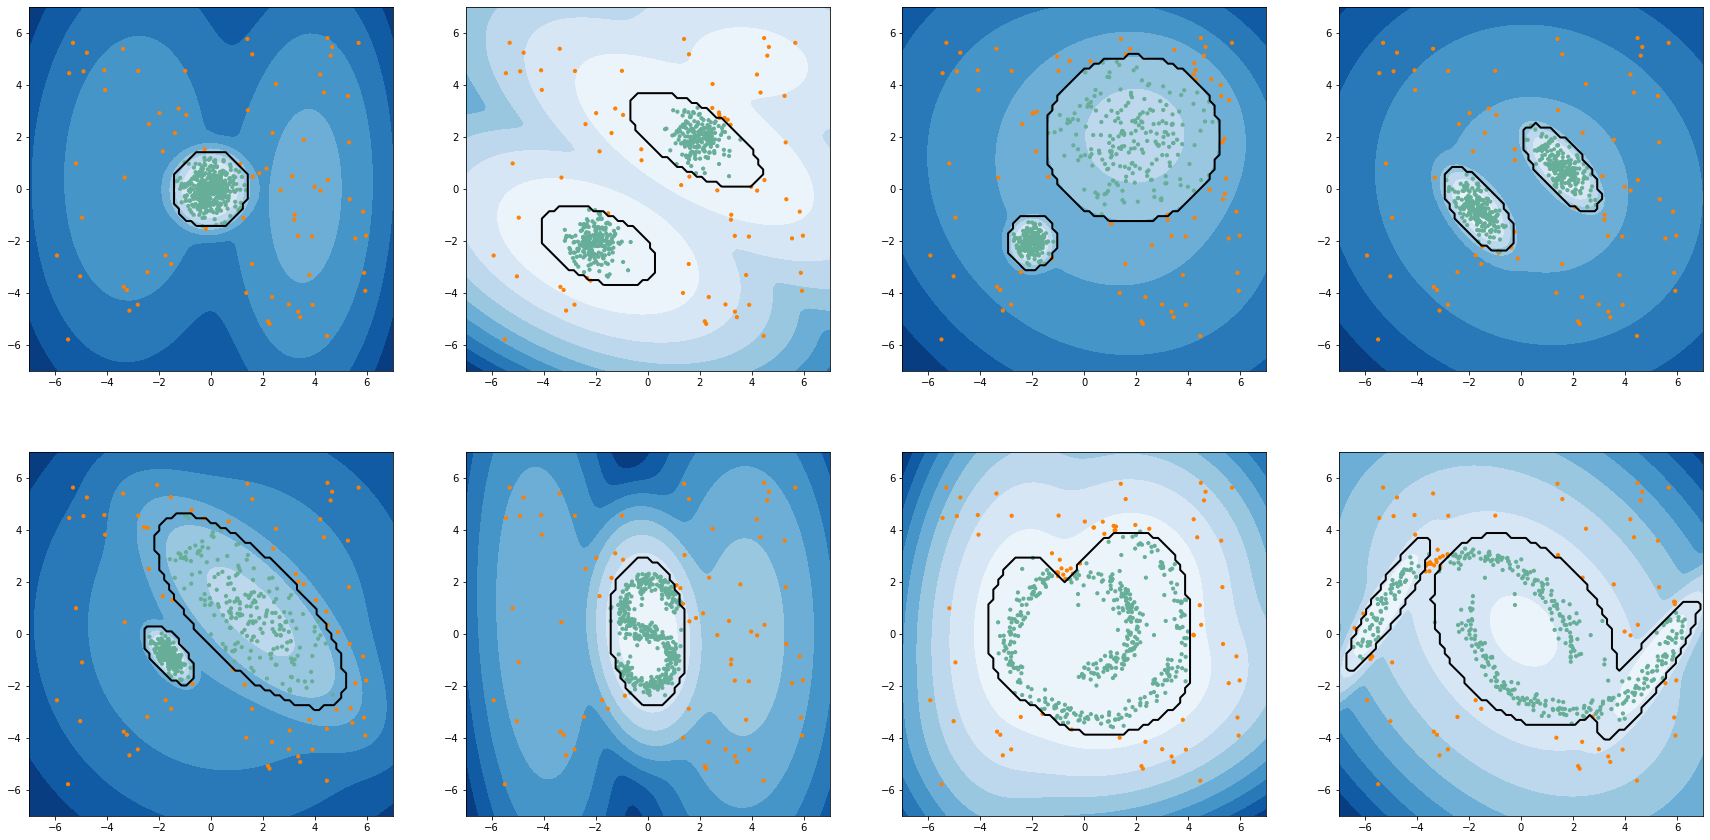

In [12]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200, n_components=3)

demo_probability_2d_data(gmm)

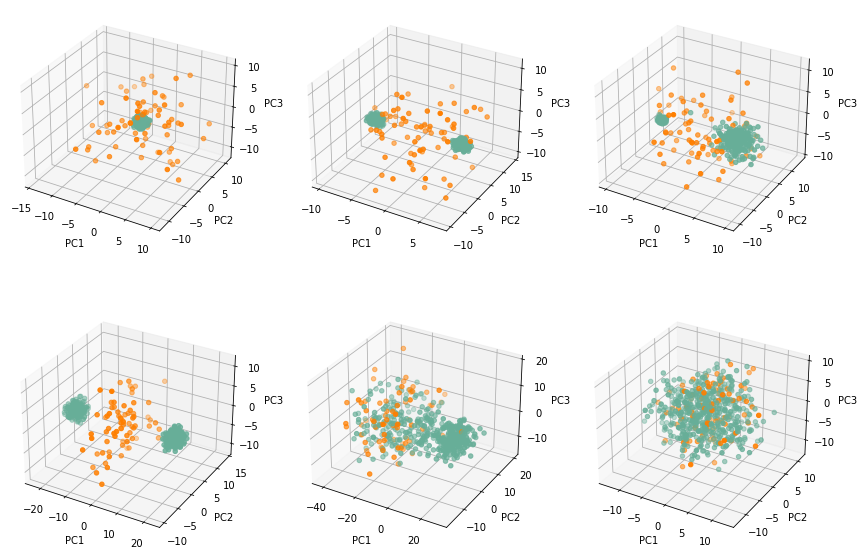

In [42]:
demo_probability_md_data(gmm)

### b. Bayesian Variational Inference Gaussian Mixture
- wip

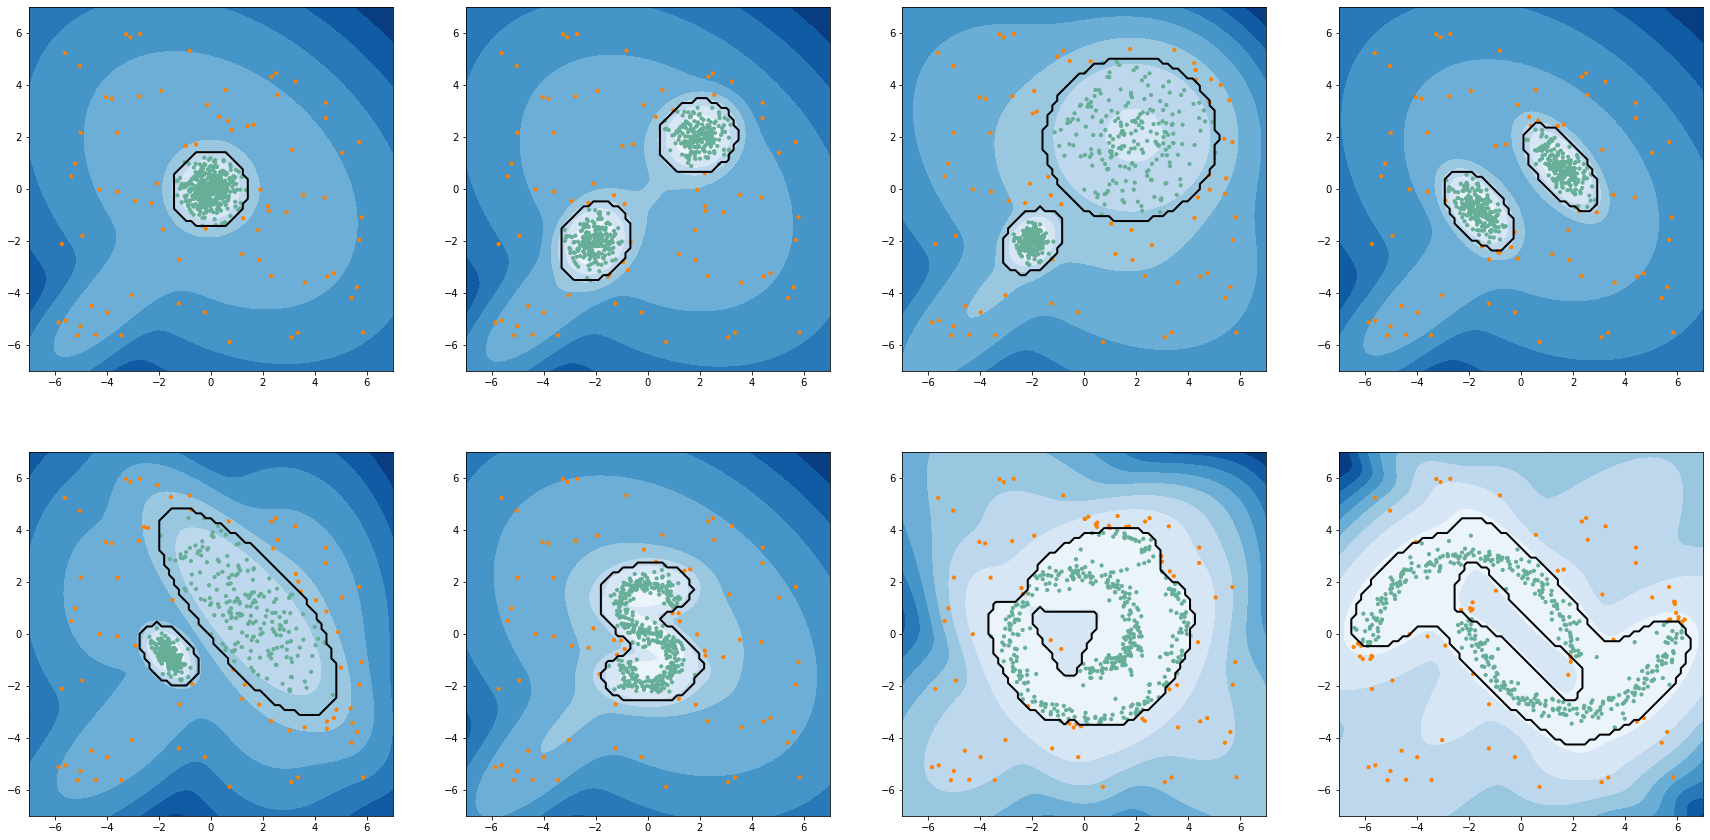

In [13]:
from sklearn.mixture import BayesianGaussianMixture
bgmm = BayesianGaussianMixture(covariance_type='full', init_params='random', weight_concentration_prior_type='dirichlet_process', weight_concentration_prior=1e2, max_iter=400, n_components=7, n_init=7)

demo_probability_2d_data(bgmm)

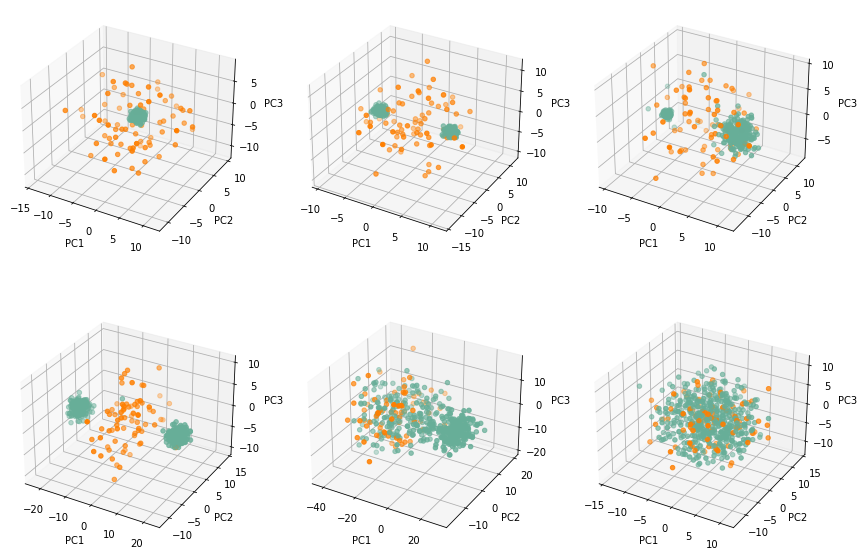

In [43]:
demo_probability_md_data(bgmm)

### c. Kernel Density Estimation
- Place a kernel over each datapoint, then the weighted average of all kernels model the probability density of the entire population (Parzen, 1962) [13] and [KDE tutorial](https://sebastianraschka.com/Articles/2014_kernel_density_est.html#73-density-estimation-via-the-parzen-window-technique-with-a-gaussian-kernel) [14]:

- Consider simple example: split the entire space into same-dimensional hypercube $C$ of equal length $h$ and volume $V = h^d$, centroid $\mathbf{x}_C$. Estimate the probability that a datapoint belongs to this hypercube $C$ by counting the number $k_C$ of datapoints bounded within it, using kernel function $\phi$, a datapoint $\mathbf{x}$ is within this hypercube if: $$
k_C = \phi(\mathbf{u}_C) = \phi\left(\frac{\mathbf{x}_C-\mathbf{x}}{h}\right) = \begin{cases}
  1 &,\ \text{if}\ \ \forall j \leq d: |u_j| \leq \frac{1}{2}\\
  0 &,\ \text{otherwise}
\end{cases}
$$
- Probability a datapoint falls into this hypercube $C$ is: $P_C = \frac{k}{n}$. The density estimation at centroid $\mathbf{x_C}$ is $\hat{p}(\mathbf{x_C}) = \frac{k/n}{V}$. If we fill the entire space with these hypercubes, then the total density integrates to 1: $\int_{-\infty}^{\infty}\text{pdf}(\mathbf{x})\ d\mathbf{x} \equiv \sum_{C}{\hat{p}(\mathbf{x}_C)}\cdot V = 1$. Rewriting $\hat{p}(\mathbf{x_C}) = \frac{k/n}{V}$ in terms of kernel function $\phi$, we can generalise this method. The density estimation at a centroid (a point) $\mathbf{x}_C$: $$ \begin{aligned}
\hat{p}(\mathbf{x_C})
  &= \frac{k/n}{V} = \frac{1}{n}\cdot \frac{1}{h^d} \cdot k\\
  &= \frac{1}{nh^d}\sum_{i=1}^{n}\phi\left(\frac{\mathbf{x}_C - \mathbf{x}_i}{h}\right)
\end{aligned} $$
- Instead of $\phi$, replace the hypercube quantile with a better probability density function, like the Gaussian kernel (bandwidth $h$ becomes $\gamma$ or sometimes $\sigma$).

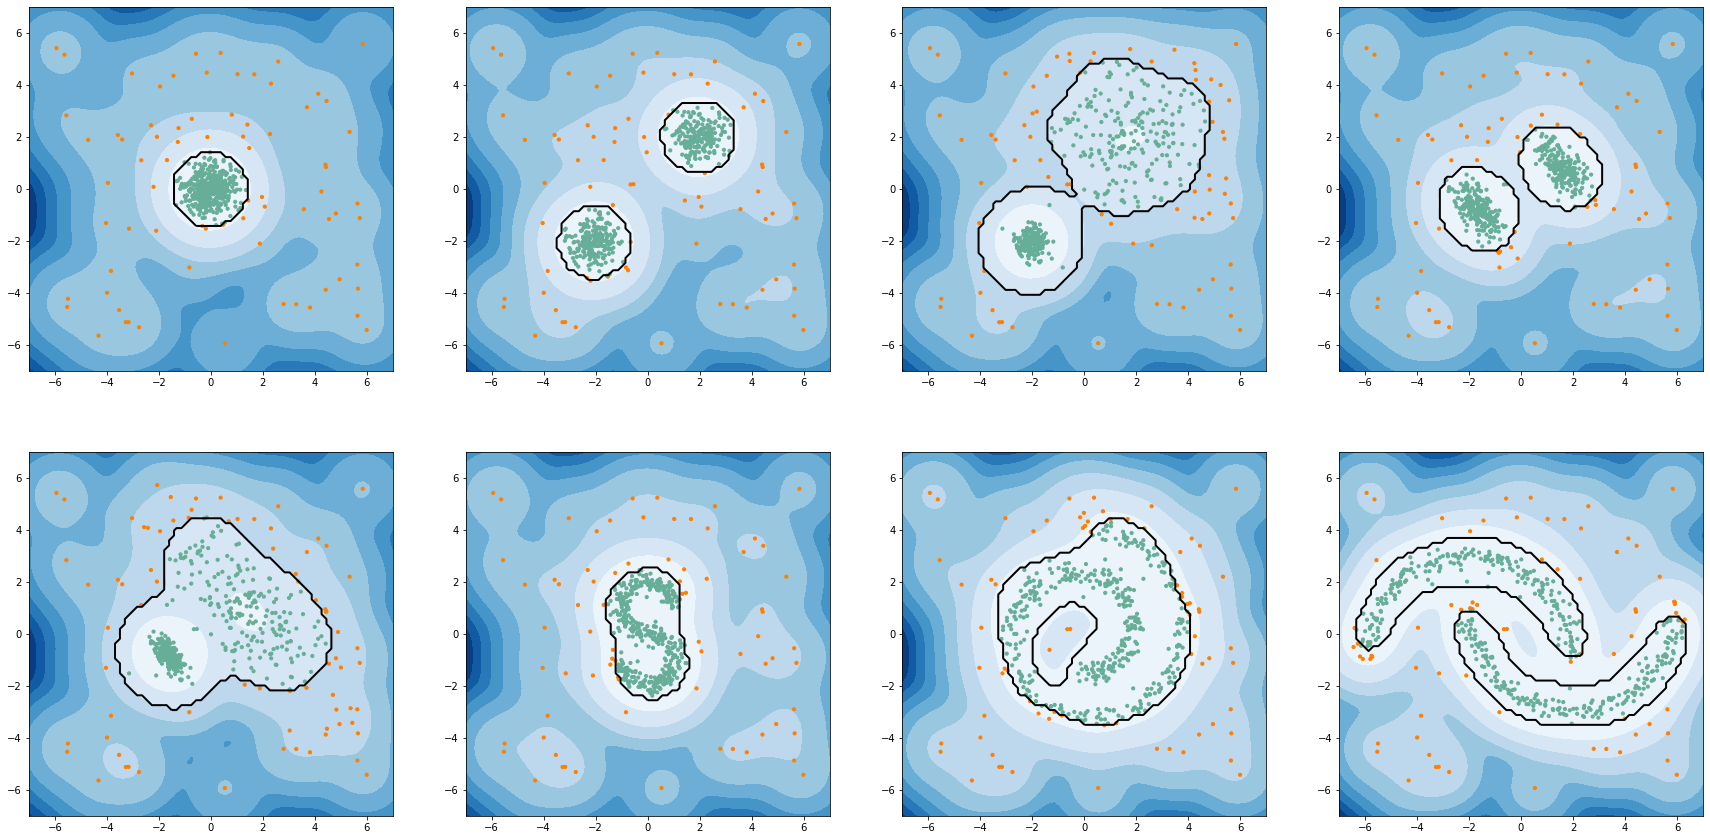

In [14]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(algorithm='auto', bandwidth=0.8, kernel='gaussian', leaf_size=35, metric='minkowski')

demo_probability_2d_data(kde)

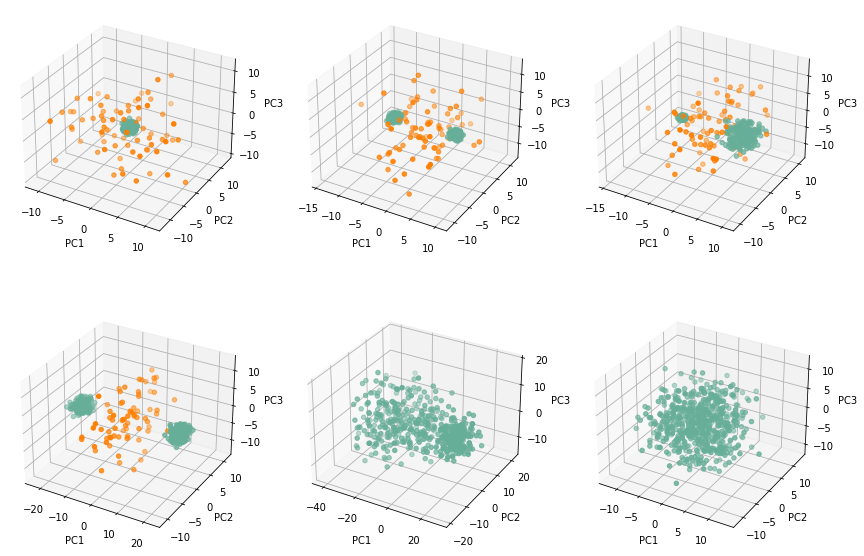

In [45]:
demo_probability_md_data(kde)

## References
- [1] Kamperis, S., 2020. Principal component analysis with Lagrange multiplier. A blog on science. Available at: https://ekamperi.github.io/mathematics/2020/11/01/principal-component-analysis-lagrange-multiplier.html [Accessed August 30, 2021]. principal-component-analysis-lagrange-multiplier.html
- [2] Roman Cheplyaka, 2017. Explained variance in PCA. Roman Cheplyaka. Available at: https://ro-che.info/articles/2017-12-11-pca-explained-variance [Accessed August 30, 2021]
- [3] Pearson, Karl. (1901). LIII. On lines and planes of closest fit to systems of points in space. https://doi.org/10.1080/14786440109462720
- [4] Breunig, M. M., Kriegel, H.-P., Ng, R. T., &amp; Sander, J. (2000). LOF: Identifying Density-Based Local Outliers. ACM SIGMOD Record, 29(2), 93–104. https://doi.org/10.1145/335191.335388
- [5] Angiulli, F., &amp; Pizzuti, C. (2002). Fast outlier detection in high dimensional spaces. Principles of Data Mining and Knowledge Discovery, 15–27.
- [6] Kriegel, H.-P., S hubert, M., &amp; Zimek, A. (2008). Angle-based outlier detection in high-dimensional data. Proceeding of the 14th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining - KDD 08.
- [7] Schölkopf, B., Platt, J. C., Shawe-Taylor, J., Smola, A. J., &amp; Williamson, R. C. (2001). Estimating the support of a high-dimensional distribution. Neural Computation, 13(7), 1443–1471. https://doi.org/10.1162/089976601750264965
- [8] Hofmann, T., Schölkopf, ‪B., &amp; Smola, A. J. (2008). Kernel Methods in Machine Learning. Institute of Mathematical Statistics, 36(3), 1171–1220.
- [9] Pevný, T. (2015). Loda: Lightweight on-line detector of anomalies. Machine Learning, 102(2), 275–304.
- [10]  Liu, F. T., Ting, K. M., &amp; Zhou, Z.-H. (2008). Isolation forest. 2008 Eighth IEEE International Conference on Data Mining. https://doi.org/10.1109/icdm.2008.17
- [11]  Shyu, M.-L., Chen, S.-C., Sarinnapakorn, K., &amp; Chang, L. W. (2003). A Novel Anomaly Detection Scheme Based on Principal Component Classifier. IEEE Foundations and New Directions of Data Mining Workshop, 311–329. https://doi.org/10.1007/11539827_18
- [12] C. M. Bishop, Pattern recognition and machine learning (Springer, 2006).
- [13] Parzen, E. (1962). On estimation of a probability density function and mode. The Annals of Mathematical Statistics, 33(3), 1065–1076. https://doi.org/10.1214/aoms/1177704472
- [14] Raschka, S. (2014, June 19). Kernel density estimation via the Parzen-rosenblatt window method. Dr. Sebastian Raschka's blog. https://sebastianraschka.com/Articles/2014_kernel_density_est.html#73-density-estimation-via-the-parzen-window-technique-with-a-gaussian-kernel